In [1]:
import csv
import warnings
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

warnings.filterwarnings('ignore')

# Style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.size': 11,
    'axes.titlesize': 18,
    'axes.titleweight': 'bold',
    'axes.labelsize': 14,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 11,
    'figure.figsize': (8, 5),
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight'
})

SIZES = ['tiny', 'small', 'base']
ARCHS = ['mlp', 'mlp_bspline', 'kan_bspline', 'kan_mean', 'kan_grkan']
SEEDS = [42, 1337, 2024]

COLORS = {
    'mlp': '#2ecc71',
    'mlp_bspline': '#f39c12',
    'kan_bspline': '#3498db',
    'kan_grkan': '#e74c3c',
    'kan_mean': '#9b59b6'
}

LABELS = {
    'mlp': 'MLP (A1)',
    'mlp_bspline': 'MLP + B-Spline (A5)',
    'kan_bspline': 'KAN B-Spline (A2)',
    'kan_grkan': 'GR-KAN (A4)',
    'kan_mean': 'KAN Mean (A3)'
}


In [2]:
from pathlib import Path
from models.config import MODEL_CONFIGS, ARCHITECTURES, SEEDS
import torch

from models.transformer import KATLanguageModelling, KATClassifier


def normalize_keys(state_dict):
	new_sd = {}
	for k, v in state_dict.items():
		if "_orig_mod." in k:
			k = k.split("_orig_mod.", 1)[1]
		if k.startswith("module."):
			k = k[len("module."):]
		new_sd[k] = v
	return new_sd

def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")


def load_models(task: str):
	model_sizes = {}
	for size in MODEL_CONFIGS.keys():
		D_MODEL = MODEL_CONFIGS[size]["d_model"]
		N_HEADS = MODEL_CONFIGS[size]["n_heads"]
		N_LAYERS = MODEL_CONFIGS[size]["n_layers"]
		model_arch = {}
		for arch in ARCHITECTURES:
			D_FF = MODEL_CONFIGS[size]["d_ff"][arch]
			model_seeds = {}
			for seed in SEEDS:
				ckpt_path = Path(f"checkpoints/{task}_{arch}_{size}_s{seed}.pt")
				if ckpt_path.exists():
					if task == "language_modelling":
						model = KATLanguageModelling(
							vocab_size=50257,
							d_model=D_MODEL,
							n_heads=N_HEADS,
							n_layers=N_LAYERS,
							ffn_type=arch,
							d_ff=D_FF,
							n_hidden=0,
							max_seq_len=256,
						)
					else:
						model = KATClassifier(
							vocab_size=50257,
							num_classes=4,
							d_model=D_MODEL,
							n_heads=N_HEADS,
							n_layers=N_LAYERS,
							n_hidden=0,
							ffn_type=arch,
							d_ff=D_FF,
							max_seq_len=512,
						)
					state_dict = normalize_keys(torch.load(ckpt_path, map_location=get_device().type))
					model.load_state_dict(state_dict)
					model_seeds[seed] = model
			model_arch[arch] = model_seeds
		model_sizes[size] = model_arch
	return model_sizes


models = load_models("classification")
#models = load_models("language_modelling")
print(models)


{'tiny': {'mlp': {42: KATLanguageModelling(
  (embedding): Embedding(50257, 192)
  (pos_embedding): Embedding(256, 192)
  (drop): Dropout(p=0.1, inplace=False)
  (layers): ModuleList(
    (0-11): 12 x CustomTransformerBlock(
      (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=192, out_features=192, bias=True)
      )
      (dropout1): Dropout(p=0.1, inplace=False)
      (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (ffn): StandardFFN(
        (net): Sequential(
          (0): Linear(in_features=192, out_features=768, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=768, out_features=192, bias=True)
        )
      )
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
  (norm_final): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
  (lm_head): Linear(in_featur

In [17]:
print(f"Sizes: {list(models.keys())}")
print(f"Archs (tiny): {list(models['tiny'].keys())}")
print(f"Seeds (tiny/mlp): {list(models['tiny']['mlp'].keys())}")

Sizes: ['tiny', 'small', 'base']
Archs (tiny): ['mlp', 'kan_bspline', 'kan_mean', 'kan_grkan', 'mlp_bspline']
Seeds (tiny/mlp): [42, 1337, 2024]


In [18]:
def extract_ffn_weights(model):
    collected_tensors = []
    processed_modules = set()

    for name, module in model.named_modules():
        if 'ffn' not in name:
            continue

        # KAN Layers (kan_bspline, kan_mean)
        if 'KANLinear' in str(type(module)):
            processed_modules.add(module)

            # Base Weight (SiLU)
            collected_tensors.append(module.base_weight.detach().cpu().flatten())

            # Effective Spline Weight (Weight * Scaler)
            w = module.spline_weight.detach().cpu()
            if hasattr(module, 'spline_scaler') and module.spline_scaler is not None:
                s = module.spline_scaler.detach().cpu().unsqueeze(-1)
                collected_tensors.append((w * s).flatten())
            else:
                collected_tensors.append(w.flatten())

        # MLP + B-Spline
        elif 'BSplineActivation' in str(type(module)):
            processed_modules.add(module)
            w = module.spline_weight.detach().cpu()
            s = module.spline_scale.detach().cpu().unsqueeze(-1)
            collected_tensors.append((w * s).flatten())

        # GR-KAN Activation (Coeffs)
        elif 'GroupRationalActivation' in str(type(module)):
             processed_modules.add(module)
             collected_tensors.append(module.numerator.detach().cpu().flatten())
             collected_tensors.append(module.denominator.detach().cpu().flatten())

    # Standard Linear Weights
    for name, param in model.named_parameters():
        if 'ffn' not in name: continue
        if any(x in name for x in ['bias', 'norm', 'grid']): continue

        is_already_processed = False
        if 'kan' in name and ('spline' in name or 'base' in name): is_already_processed = True
        if 'activation' in name and ('numerator' in name or 'denominator' in name or 'spline' in name): is_already_processed = True

        # GR-KAN and MLP: Linear Layers (projections)
        if not is_already_processed and 'weight' in name:
            collected_tensors.append(param.detach().cpu().flatten())

    return torch.cat(collected_tensors) if collected_tensors else torch.tensor([])


def compute_weight_metrics(weights, threshold=0.01):
    if len(weights) == 0:
        return {'sparsity': np.nan, 'std': np.nan, 'l1_norm': np.nan, 'n_params': 0}
    w = weights.float()
    return {
        'sparsity': (w.abs() < threshold).float().mean().item(),
        'std': w.std().item(),
        'l1_norm': w.abs().mean().item(),
        'n_params': len(w)
    }

In [19]:
def collect_all_metrics(models):
    results = []

    for size in SIZES:
        for arch in ARCHS:
            for seed in SEEDS:
                model = models[size][arch][seed]
                model.eval()

                weights = extract_ffn_weights(model)
                metrics = compute_weight_metrics(weights)

                results.append({
                    'size': size,
                    'arch': arch,
                    'seed': seed,
                    'sparsity': metrics['sparsity'],
                    'std': metrics['std'],
                    'l1_norm': metrics['l1_norm'],
                    'n_params': metrics['n_params'],
                })

    return pd.DataFrame(results)

# Collect
df_raw = collect_all_metrics(models)
print(f"Collected: {len(df_raw)} data points")
df_raw

Collected: 45 data points


,size,arch,seed,sparsity,std,l1_norm,n_params,kan_ratio
0,tiny,mlp,42,0.394596,0.019385,0.015462,3538944,NaN
1,tiny,mlp,1337,0.394754,0.019375,0.015453,3538944,NaN
2,tiny,mlp,2024,0.394478,0.019378,0.015458,3538944,NaN
3,tiny,mlp_bspline,42,0.394155,0.019431,0.015487,3686400,NaN
4,tiny,mlp_bspline,1337,0.394147,0.019432,0.015489,3686400,NaN
5,tiny,mlp_bspline,2024,0.393758,0.019415,0.015479,3686400,NaN
6,tiny,kan_bspline,42,0.902103,0.017677,0.005325,3193344,111.929383
7,tiny,kan_bspline,1337,0.901923,0.017667,0.005320,3193344,113.261772
8,tiny,kan_bspline,2024,0.902076,0.017685,0.005336,3193344,109.092136
9,tiny,kan_mean,42,0.901956,0.017657,0.005242,3193344,145.865229


In [20]:
# Aggregation over seeds
df_agg = df_raw.groupby(['size', 'arch']).agg({
    'sparsity': ['mean', 'std'],
    'std': ['mean', 'std'],
    'l1_norm': ['mean', 'std'],
    'n_params': 'first'
}).round(4)

df_agg.columns = ['_'.join(col).strip('_') for col in df_agg.columns]
df_agg = df_agg.reset_index()

# Sort
size_order = {'tiny': 0, 'small': 1, 'base': 2}
arch_order = {a: i for i, a in enumerate(ARCHS)}
df_agg['size_order'] = df_agg['size'].map(size_order)
df_agg['arch_order'] = df_agg['arch'].map(arch_order)
df_agg = df_agg.sort_values(['size_order', 'arch_order']).drop(columns=['size_order', 'arch_order'])

df_agg

,size,arch,sparsity_mean,sparsity_std,std_mean,std_std,l1_norm_mean,l1_norm_std,kan_ratio_mean,kan_ratio_std,n_params_first
13,tiny,mlp,0.3946,0.0001,0.0194,0.0000,0.0155,0.0000,NaN,NaN,3538944
14,tiny,mlp_bspline,0.3940,0.0002,0.0194,0.0000,0.0155,0.0000,NaN,NaN,3686400
10,tiny,kan_bspline,0.9020,0.0001,0.0177,0.0000,0.0053,0.0000,111.4278,2.1296,3193344
12,tiny,kan_mean,0.9020,0.0001,0.0177,0.0000,0.0052,0.0000,144.6584,1.5738,3193344
11,tiny,kan_grkan,0.3905,0.0001,0.0206,0.0000,0.0157,0.0000,NaN,NaN,3540864
8,small,mlp,0.4145,0.0078,0.0184,0.0003,0.0147,0.0003,NaN,NaN,14155776
9,small,mlp_bspline,0.4003,0.0089,0.0191,0.0004,0.0152,0.0004,NaN,NaN,14450688
5,small,kan_bspline,0.9081,0.0005,0.0121,0.0003,0.0036,0.0001,120.7857,8.7588,12773376
7,small,kan_mean,0.9084,0.0000,0.0119,0.0000,0.0035,0.0000,144.7250,1.6702,12773376
6,small,kan_grkan,0.4089,0.0003,0.0189,0.0000,0.0149,0.0000,NaN,NaN,14157696


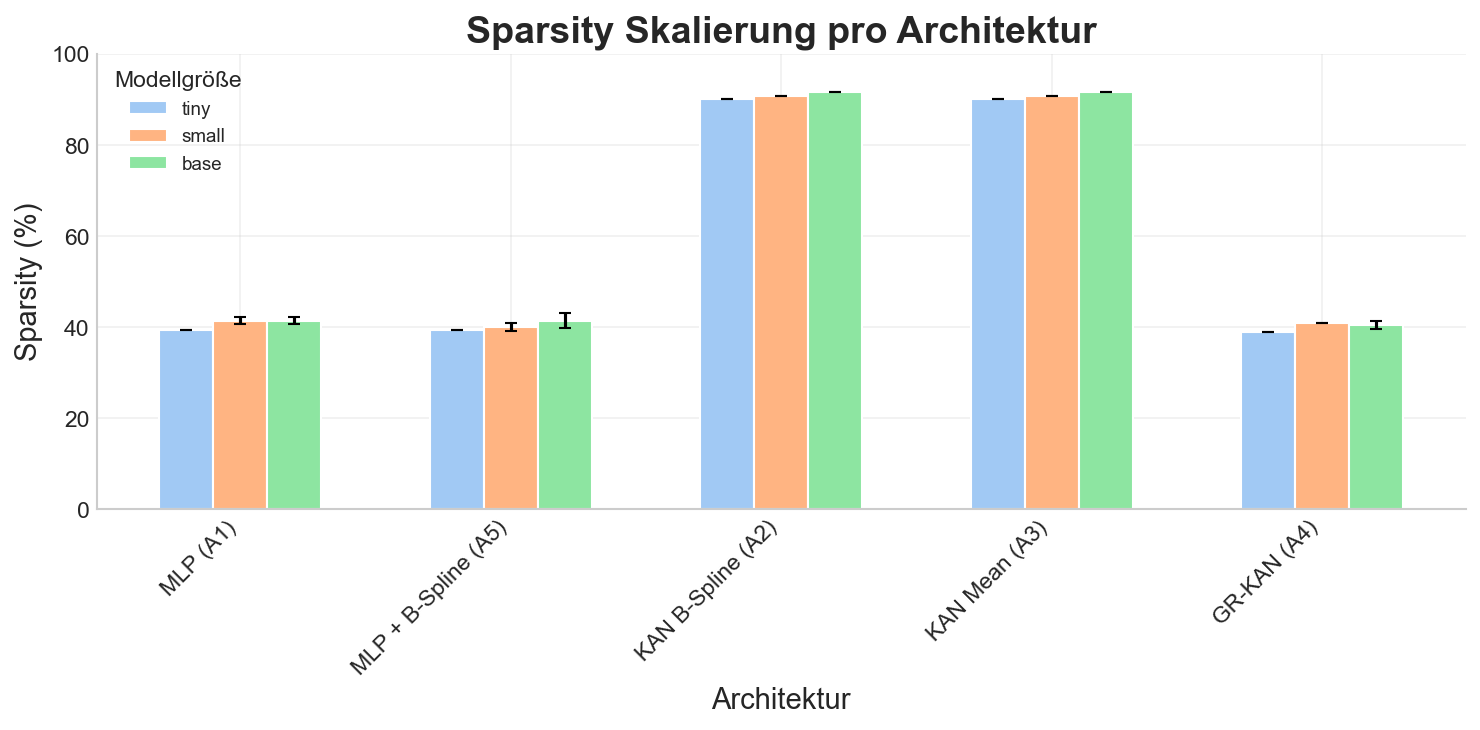

In [22]:
def plot_sparsity_scaling(df):
    fig, ax = plt.subplots(figsize=(10, 5))

    SIZES_ORDER = ['tiny', 'small', 'base']

    SIZE_COLORS = {
        'tiny': '#a1c9f4',
        'small': '#ffb482',
        'base': '#8de5a1'
    }

    x = np.arange(len(ARCHS))
    width = 0.2
    offsets = [-1, 0, 1]

    # Loop sizes
    for i, size in enumerate(SIZES_ORDER):
        # Filter by size
        df_size = df[df['size'] == size].copy()

        df_size['arch_cat'] = pd.Categorical(df_size['arch'], categories=ARCHS, ordered=True)
        df_size = df_size.sort_values('arch_cat')

        means = df_size['sparsity_mean'].values * 100
        stds = df_size['sparsity_std'].values * 100

        # Plot
        ax.bar(x + offsets[i] * width, means, width,
               yerr=stds, capsize=3,
               color=SIZE_COLORS.get(size, 'grey'),
               label=LABELS.get(size, size),
               alpha=1, edgecolor='white')

    ax.set_xticks(x)
    xtick_labels = [LABELS[arch] if 'LABELS' in globals() and arch in LABELS else arch for arch in ARCHS]
    ax.set_xticklabels(xtick_labels, rotation=45, ha='right')

    ax.set_xlabel('Architektur')
    ax.set_ylabel('Sparsity (%)')
    ax.set_title('Sparsity Skalierung pro Architektur', fontsize=18)

    # Legend
    ax.legend(title='Modellgröße', loc='upper left', fontsize=9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 100)

    plt.tight_layout()
    plt.savefig('results/interpretability_sparsity_scaling.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_sparsity_scaling(df_agg)

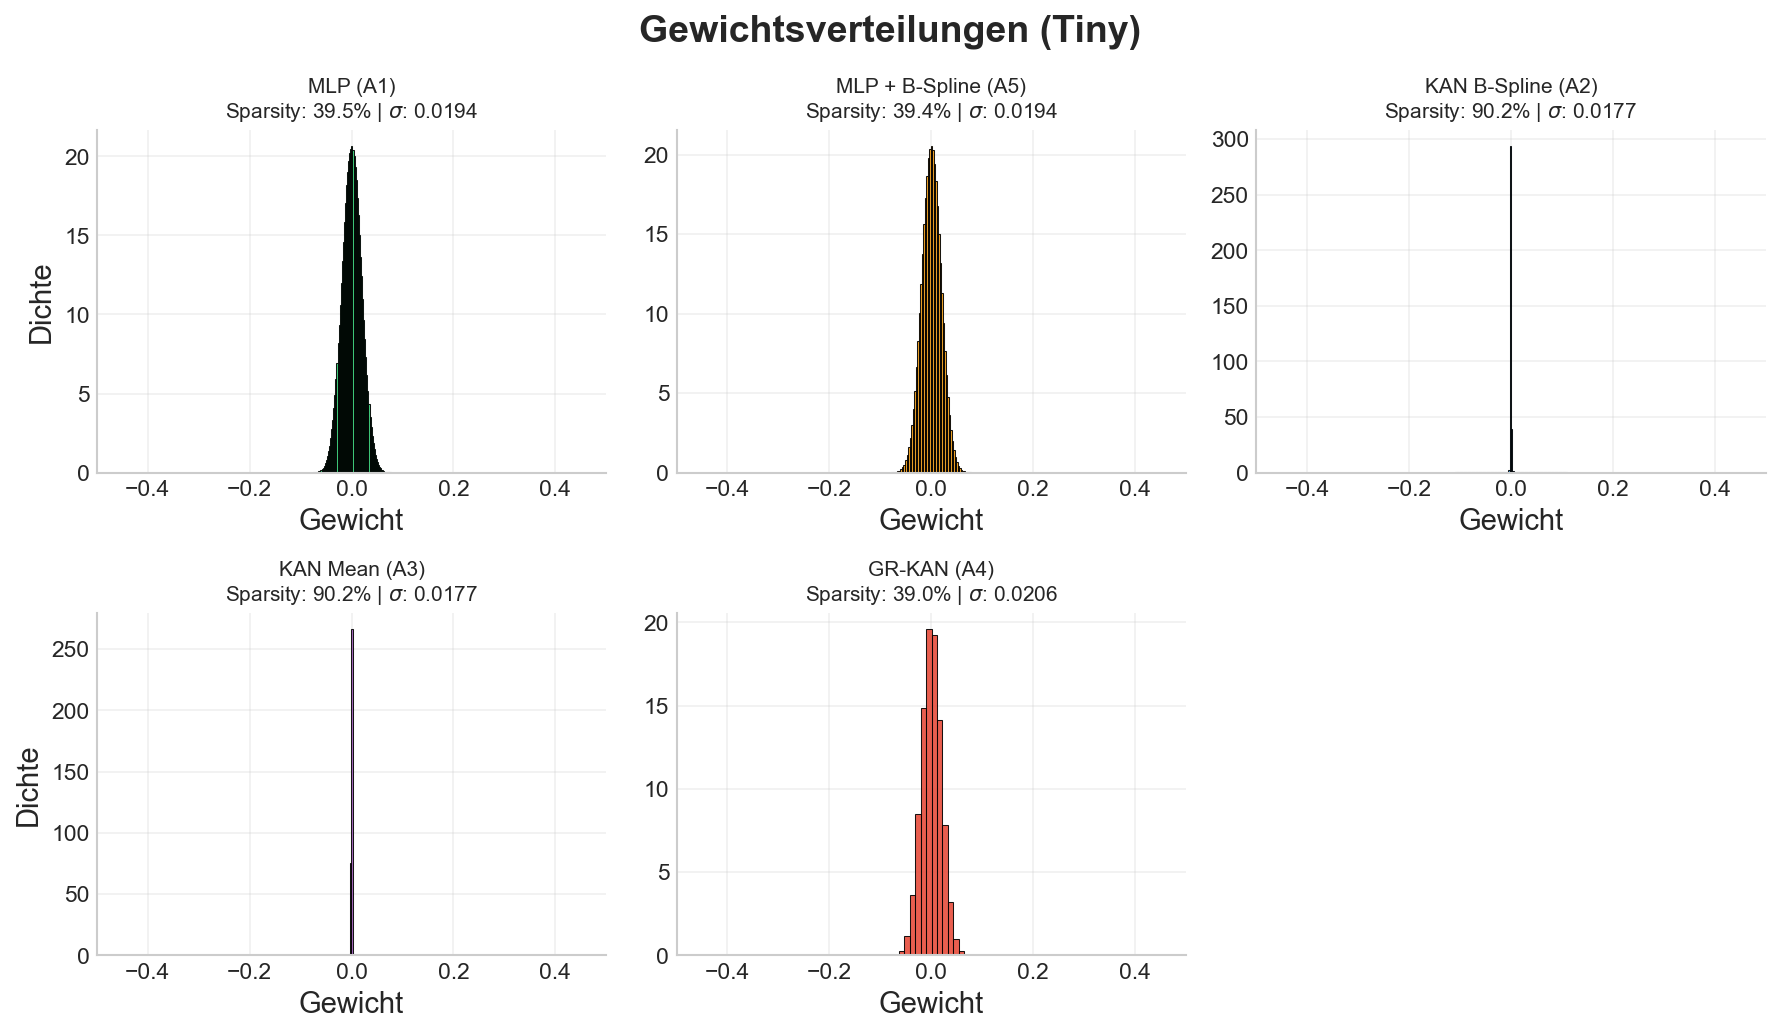

In [24]:
import seaborn as sns
def plot_weight_histograms(models, size='tiny', seed=42):
    fig, axes = plt.subplots(2, 3, figsize=(12, 7))
    axes_flat = axes.flatten()

    for idx, arch in enumerate(ARCHS):
        ax = axes_flat[idx]
        model = models[size][arch][seed]
        weights = extract_ffn_weights(model).numpy()

        # Calculate metrics
        sparsity = (np.abs(weights) < 0.01).mean() * 100
        std_dev = np.std(weights)

        # Histogram
        ax.hist(weights,
        bins=100,
        color=COLORS[arch],
        alpha=0.9,
        density=True,
        edgecolor='black',
        linewidth=0.5)
        # Title
        title_text = f'{LABELS[arch]}\nSparsity: {sparsity:.1f}% | $\sigma$: {std_dev:.4f}'
        ax.set_title(title_text, fontsize=10, fontweight='normal')

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(True, alpha=0.3)
        ax.set_xlim(-0.5, 0.5)
        ax.set_xlabel('Gewicht')

        # Y-Label
        if idx % 3 == 0:
            ax.set_ylabel('Dichte')

    # Hide empty subplots
    for i in range(len(ARCHS), len(axes_flat)):
        axes_flat[i].set_visible(False)

    plt.suptitle(f'Gewichtsverteilungen ({size.capitalize()})', fontweight='bold', fontsize=18)
    plt.tight_layout()
    plt.savefig(f'results/interpretability_weights_{size}.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_weight_histograms(models, 'tiny')

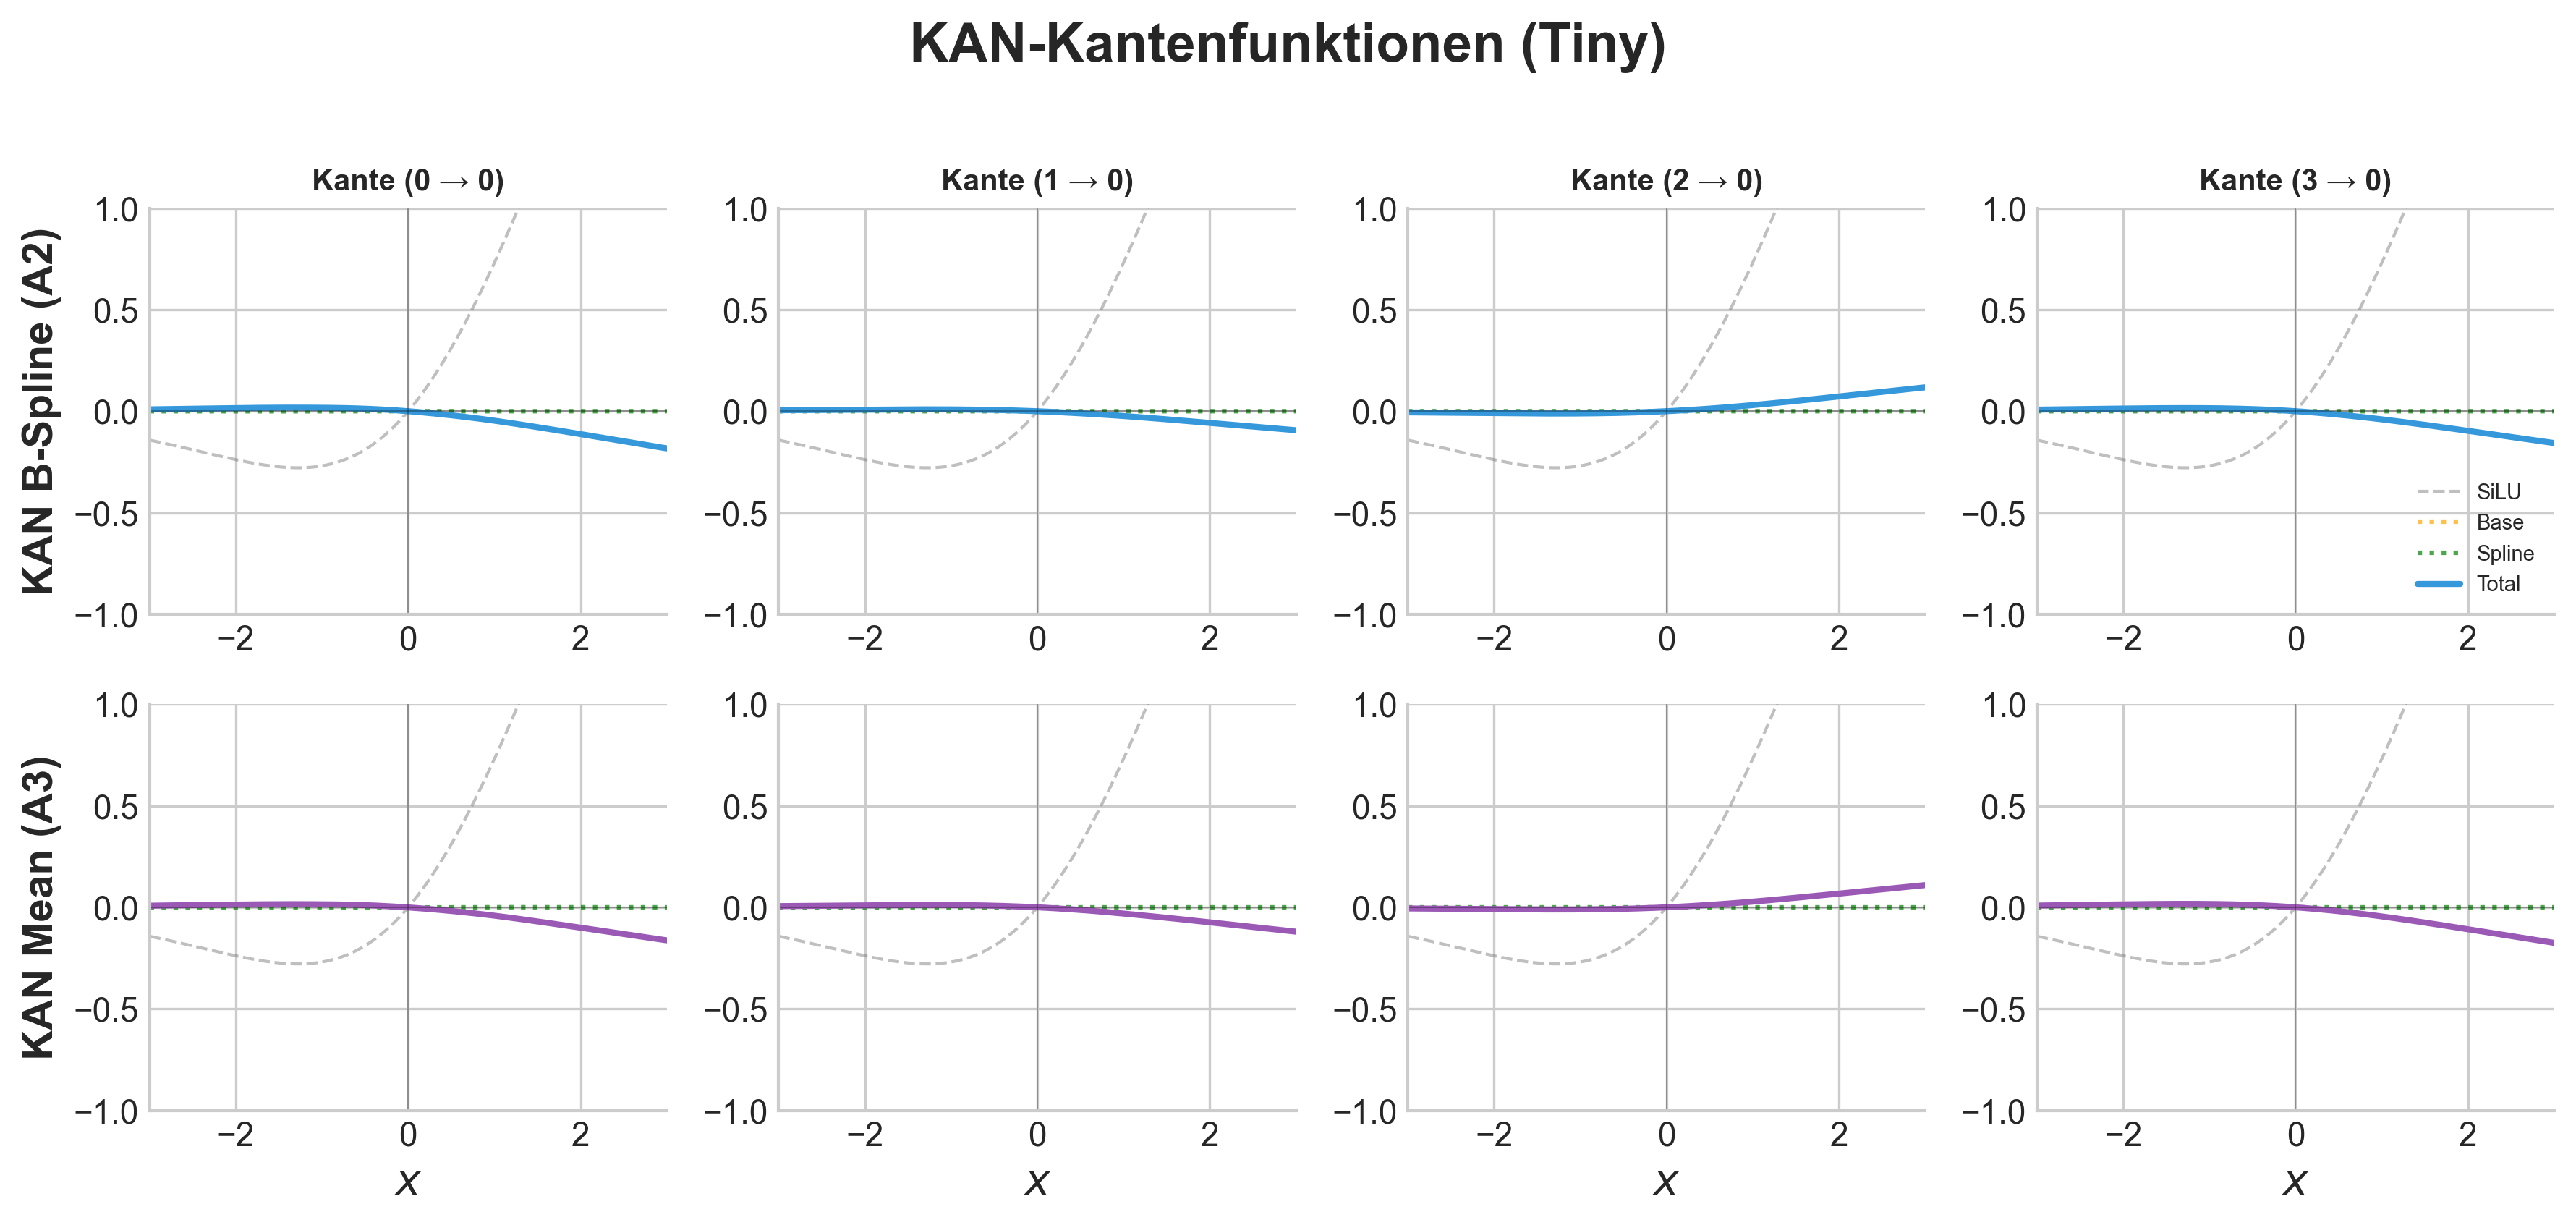

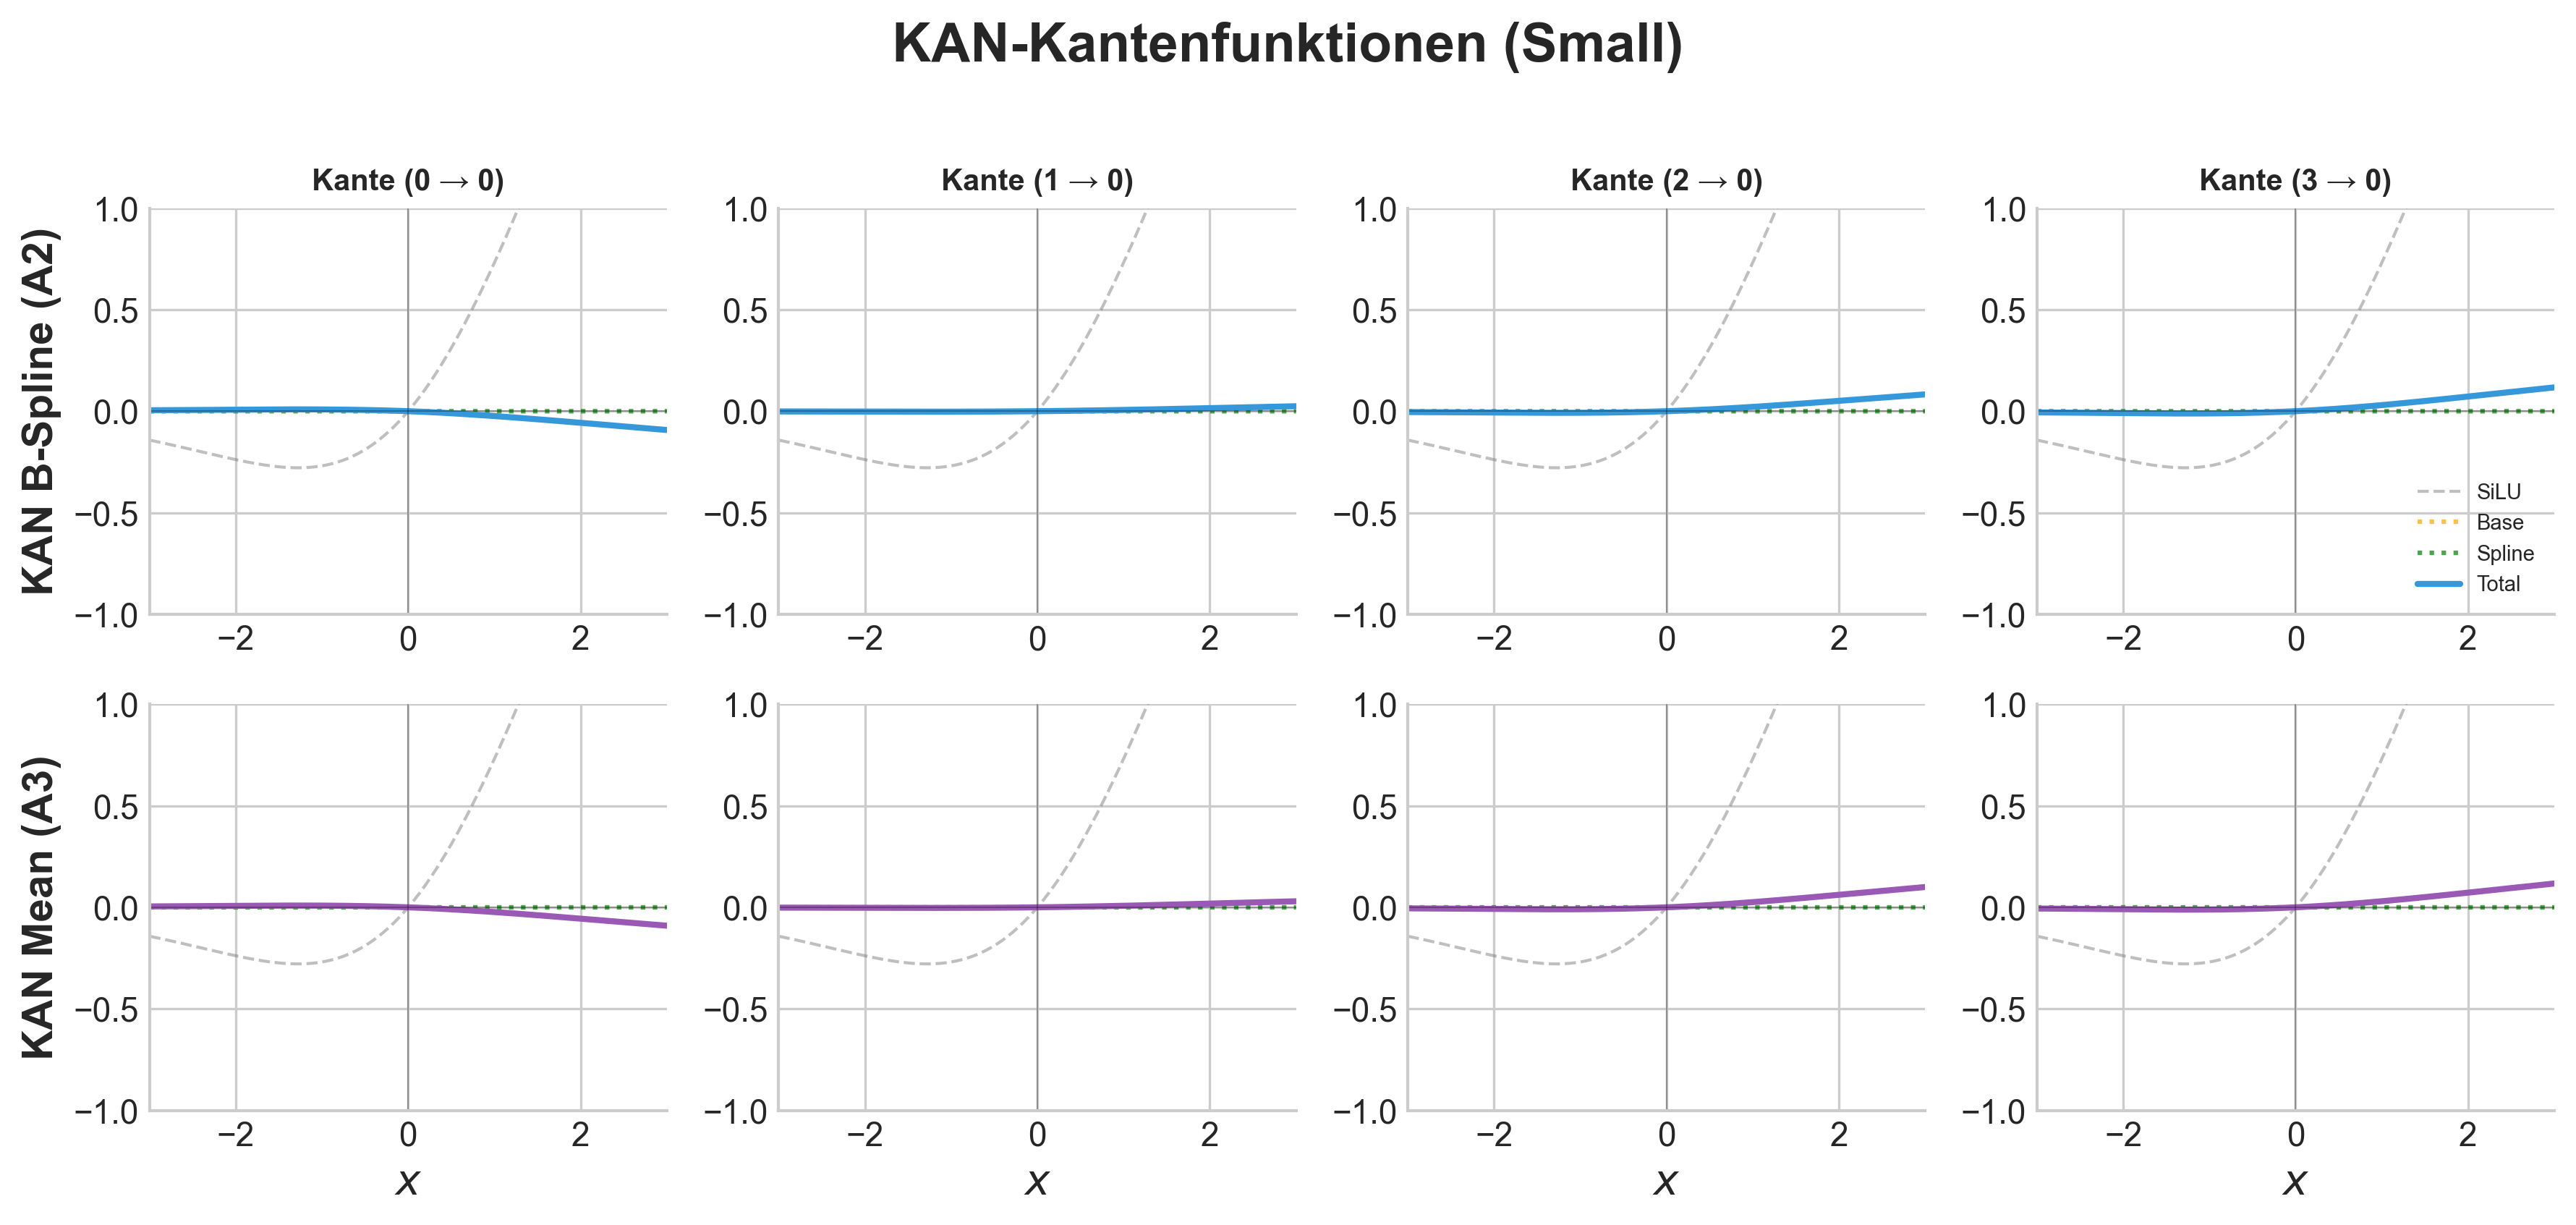

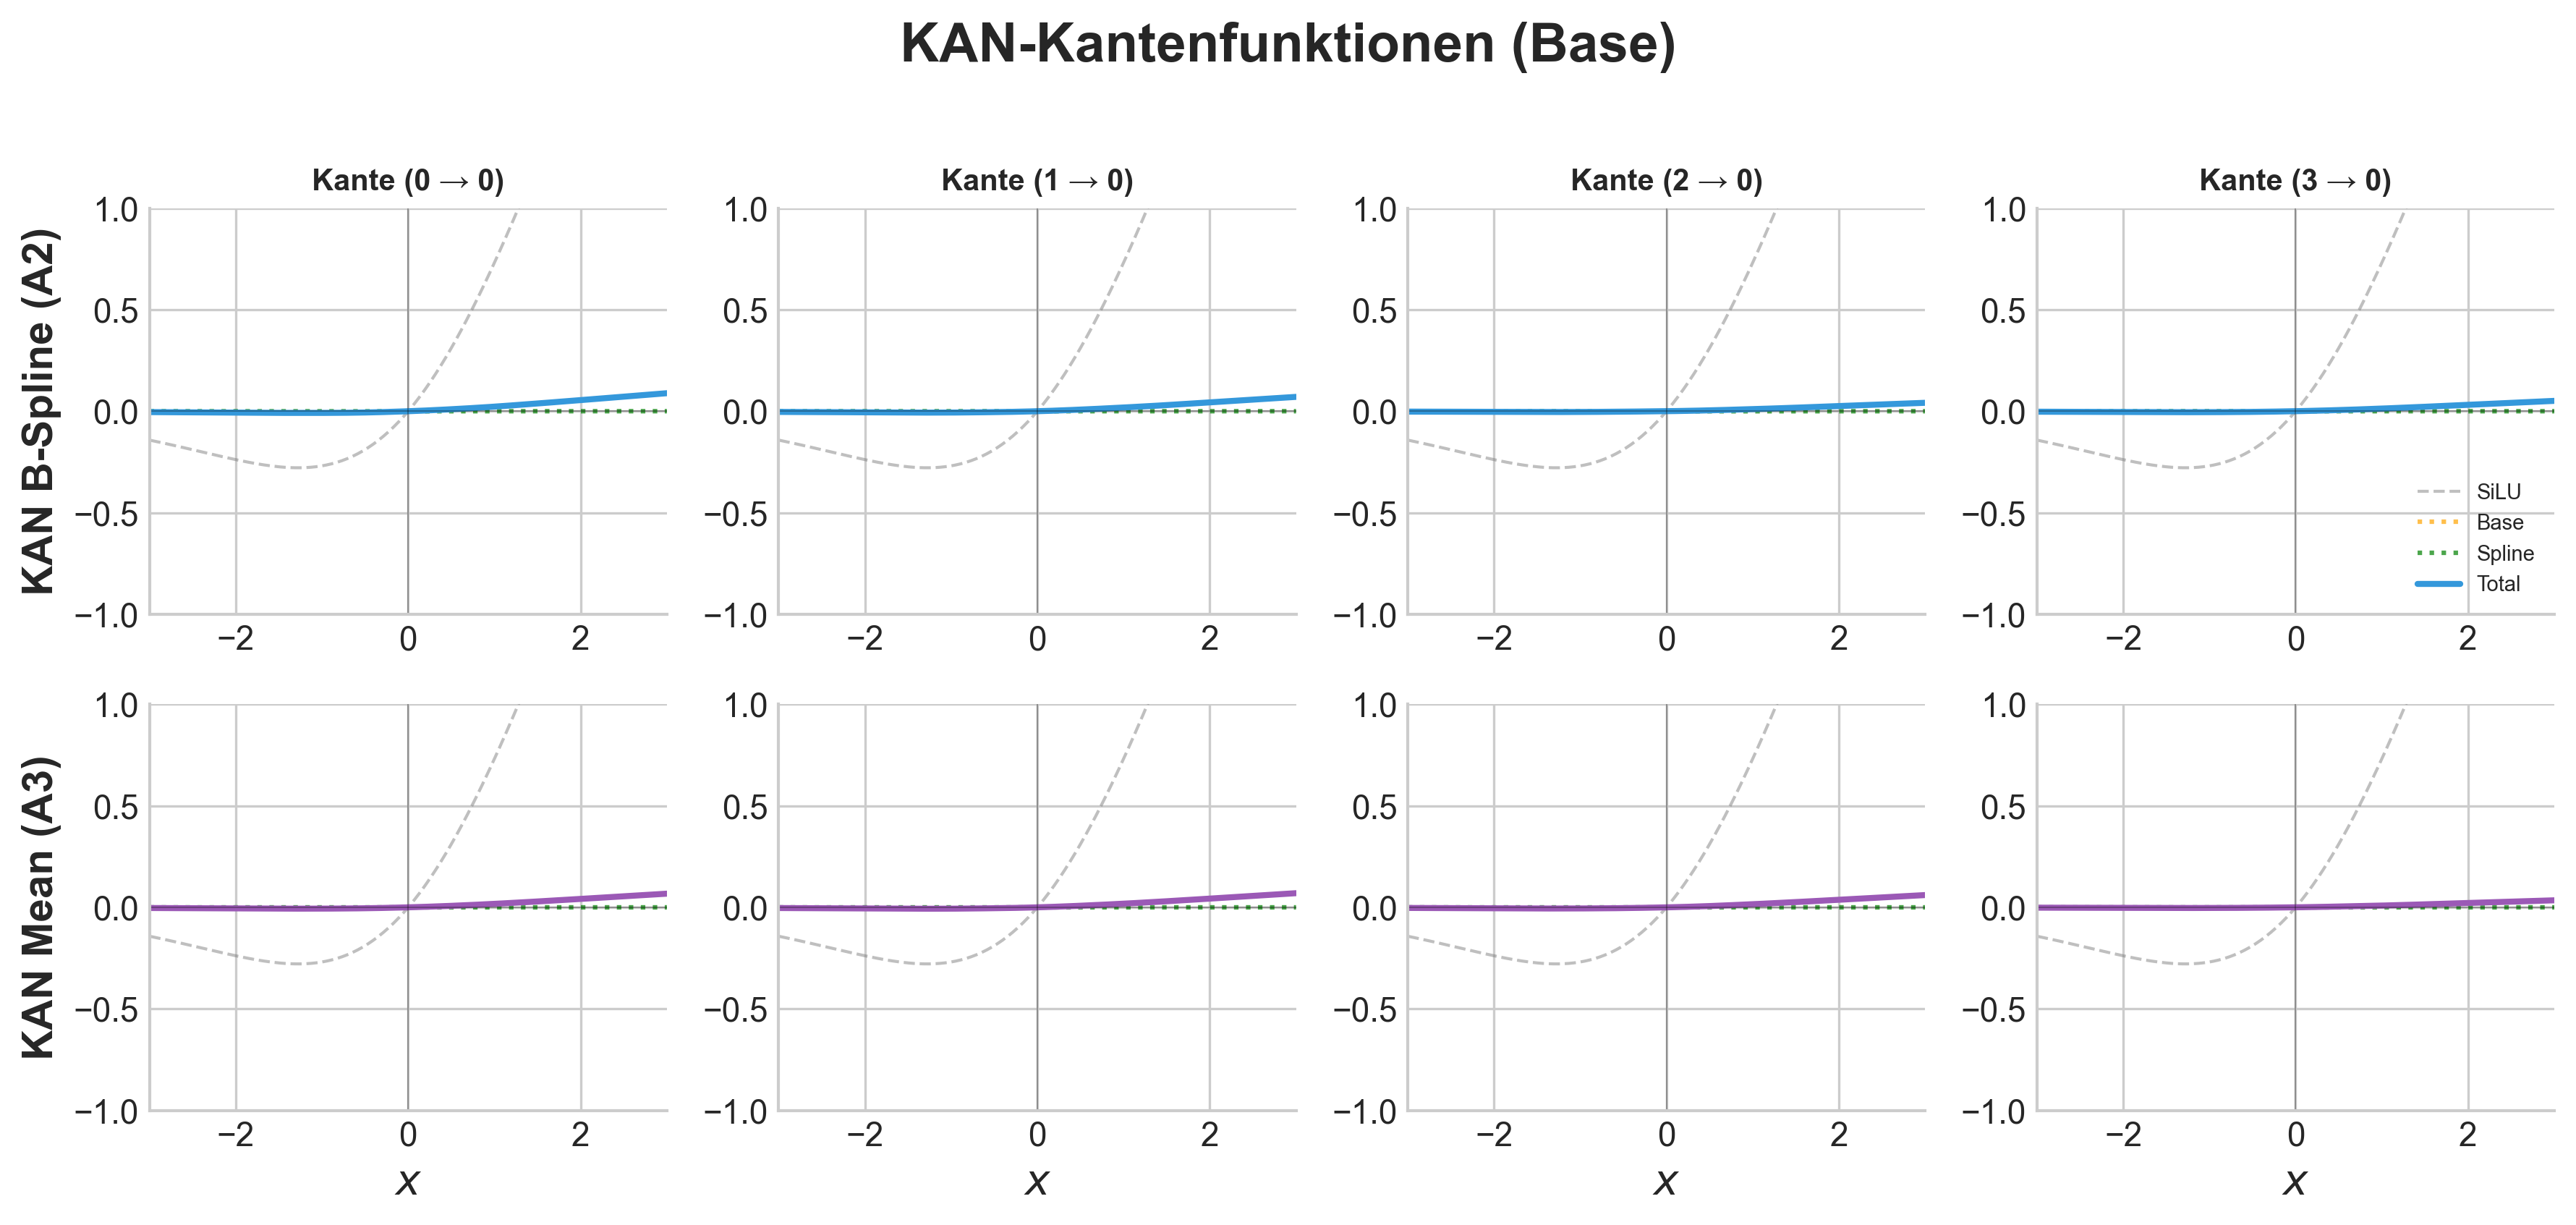

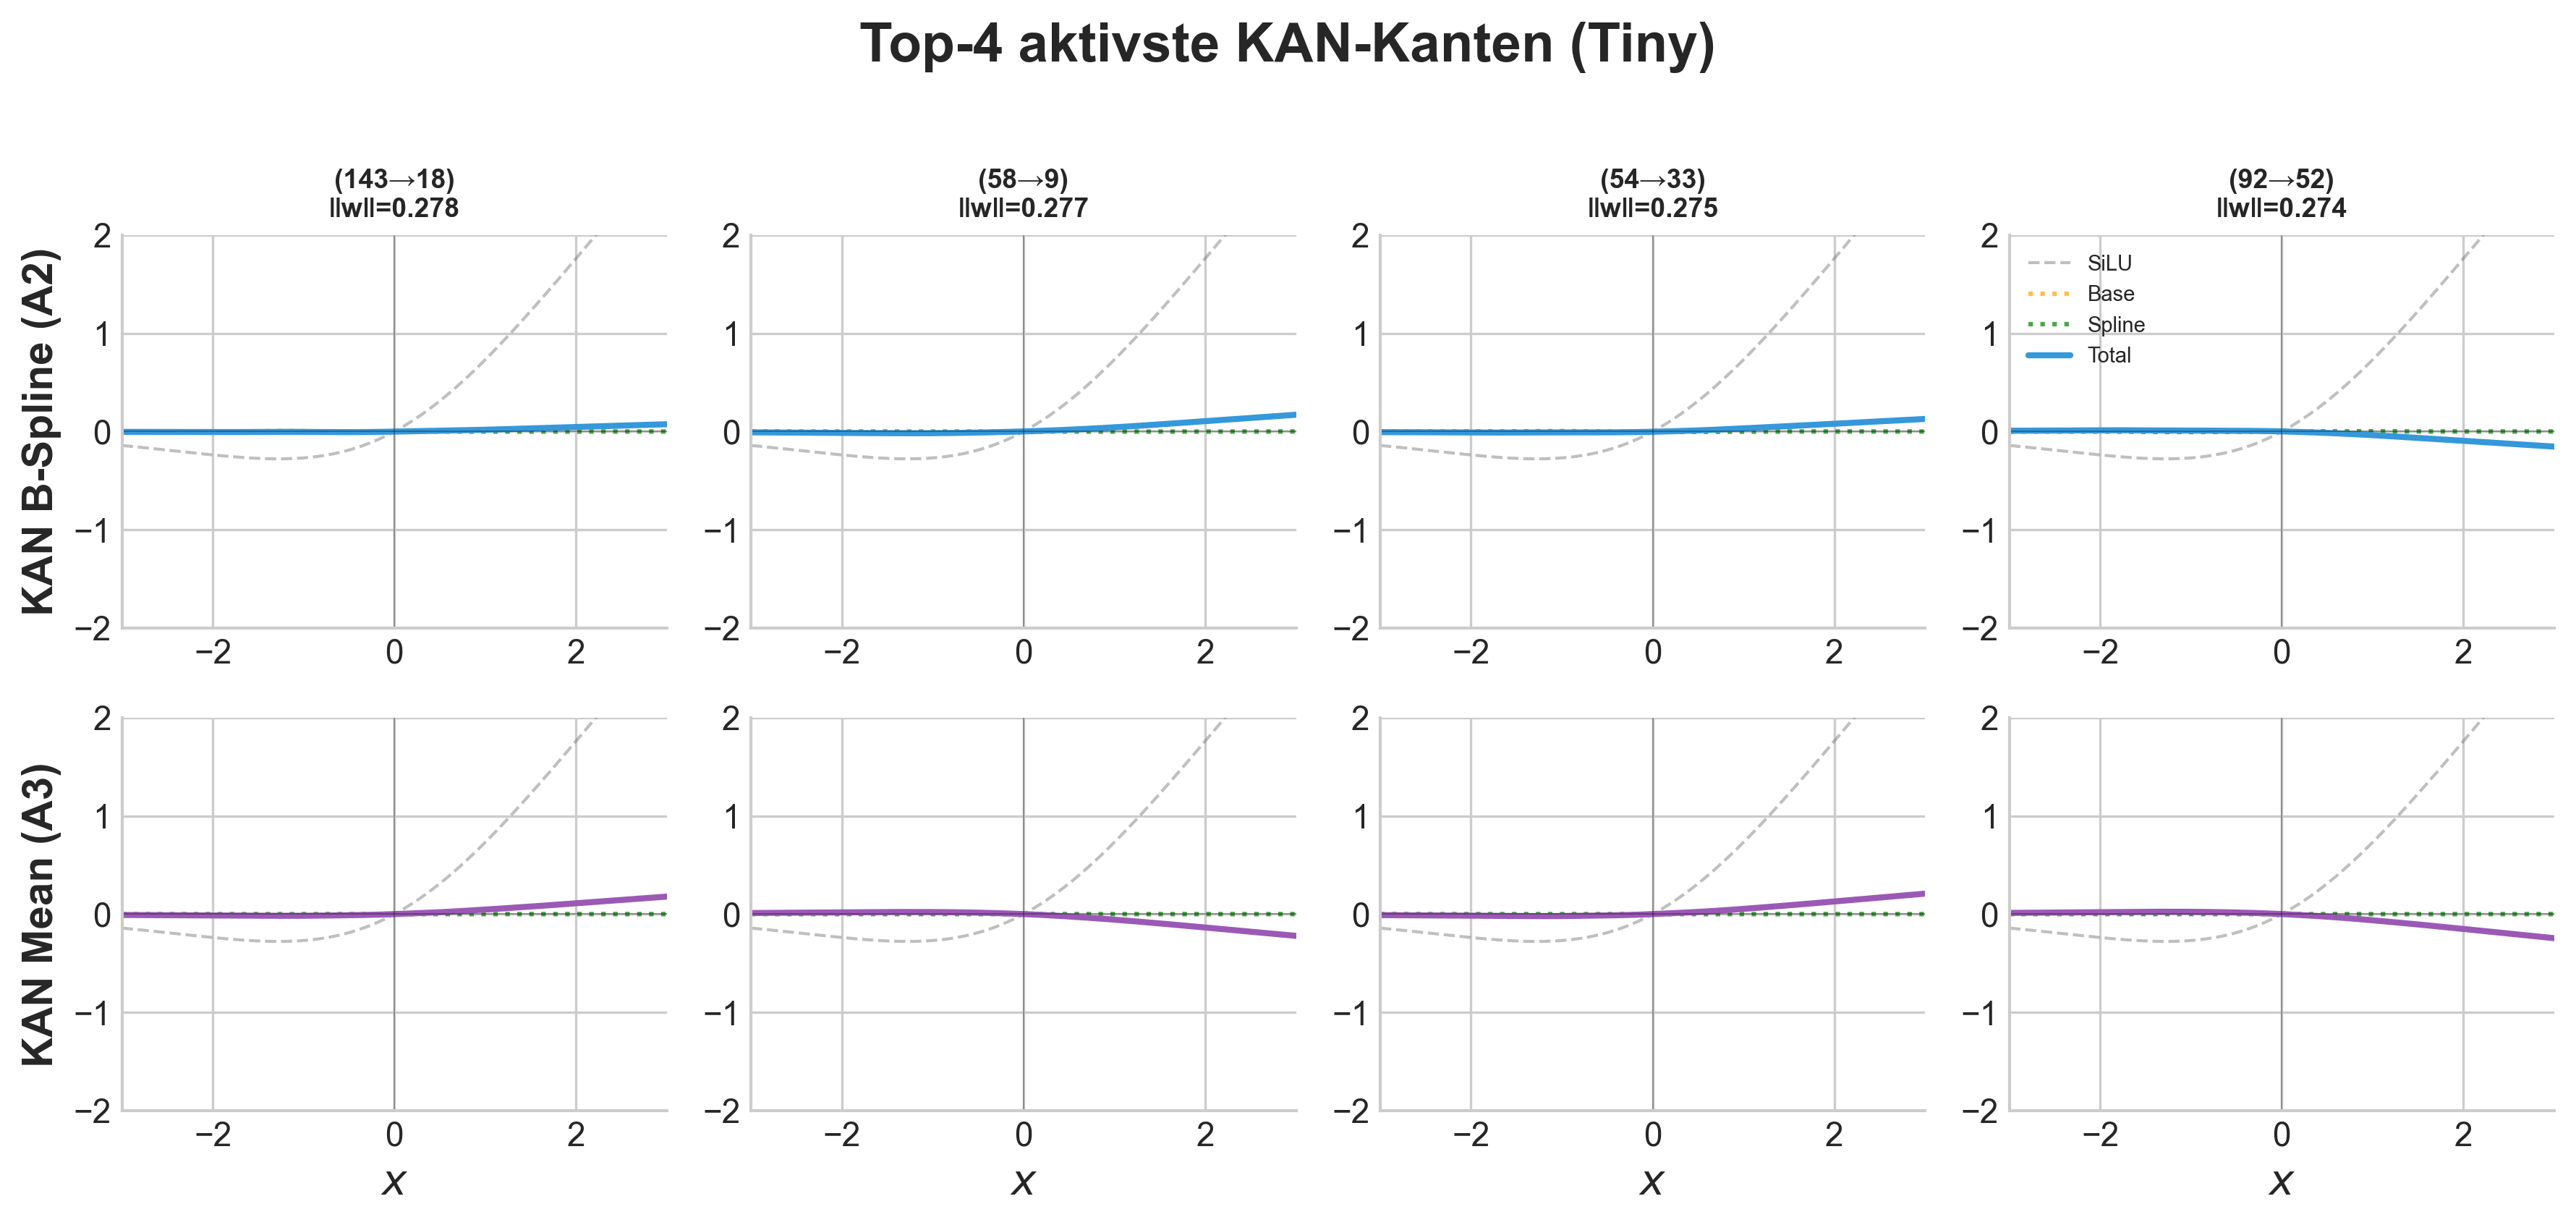

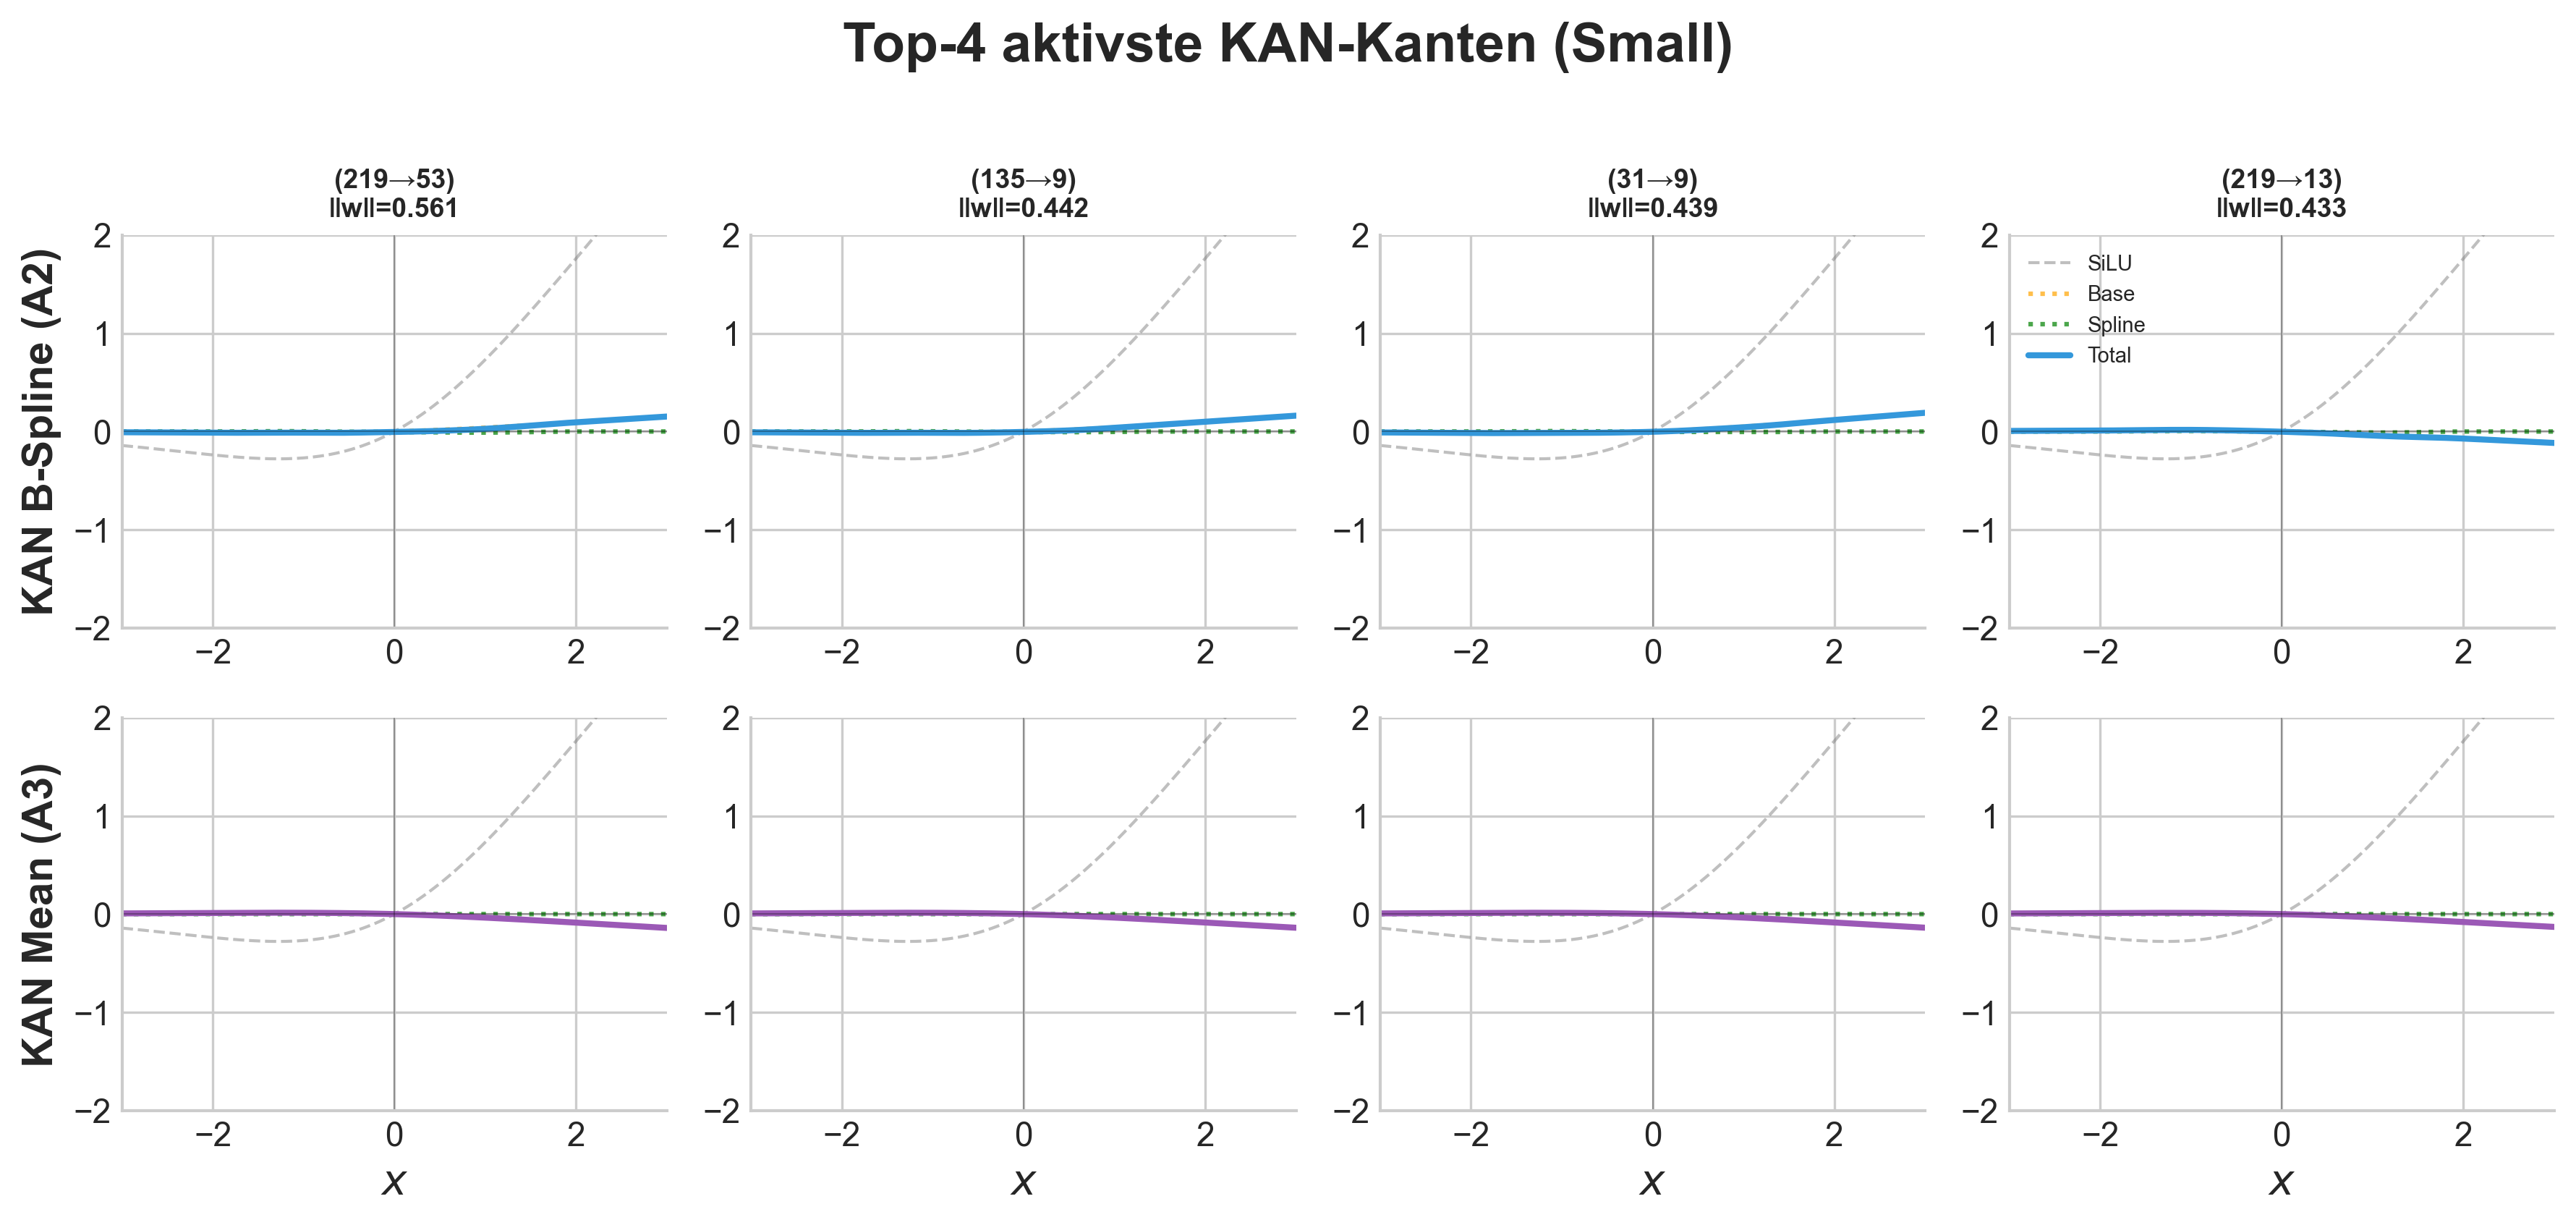

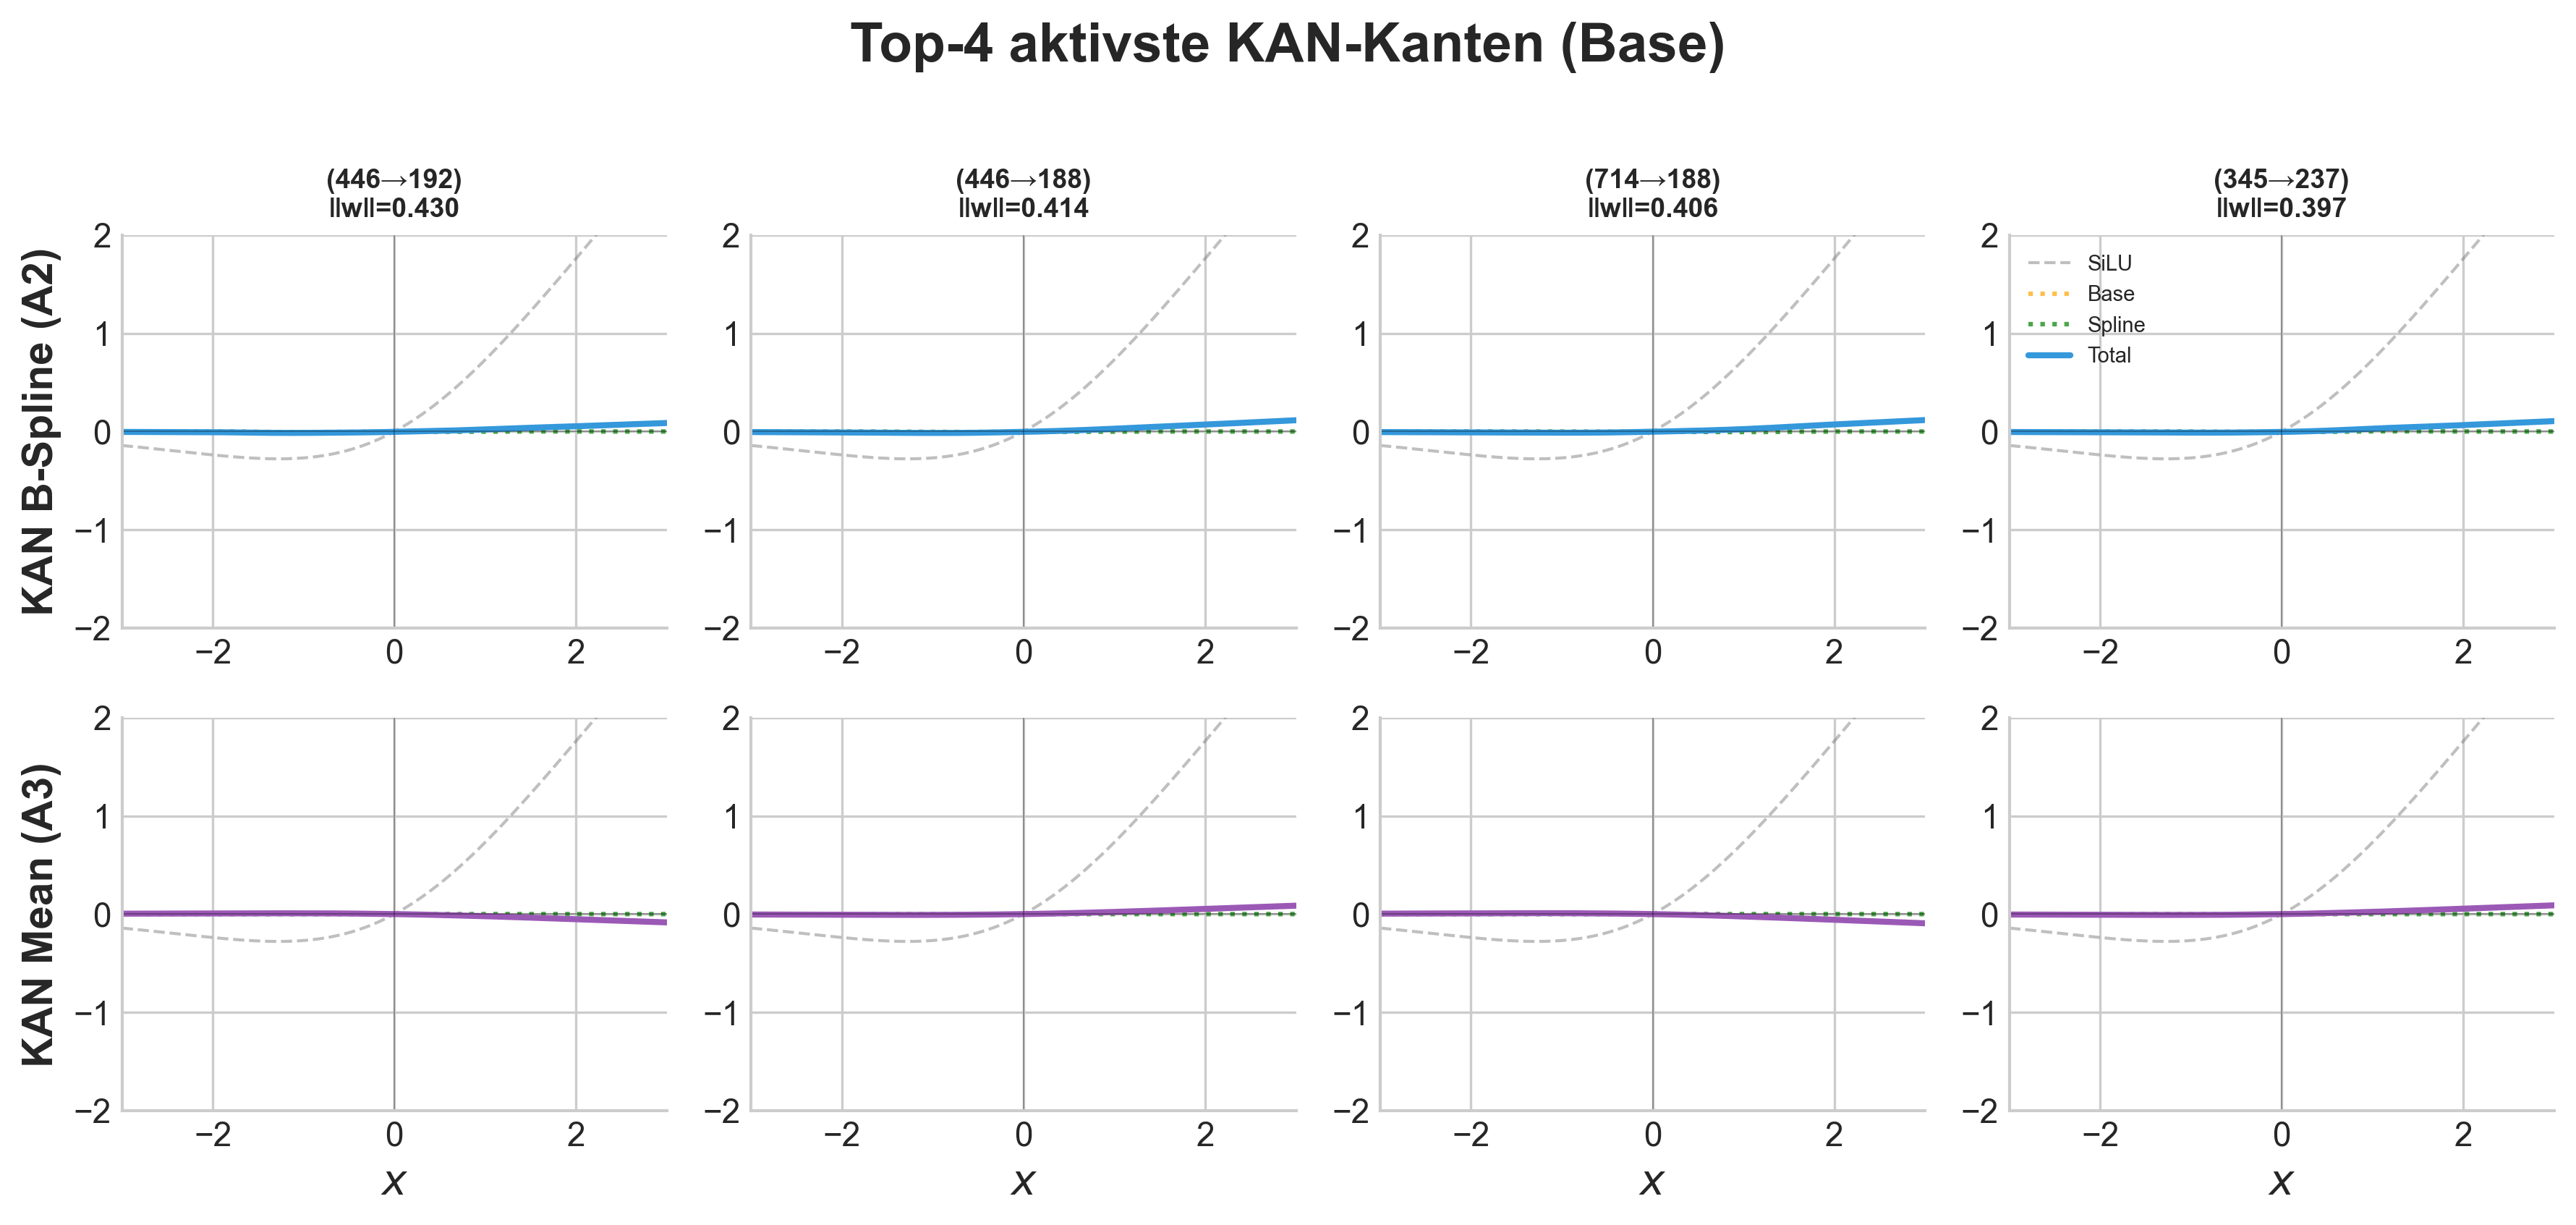

In [26]:
def plot_kan_activations(models, size='tiny', seed=42):
    fig, axes = plt.subplots(2, 4, figsize=(12, 5.5), dpi=300)

    x = torch.linspace(-3, 3, 200)
    silu_ref = F.silu(x).numpy()

    for row, arch in enumerate(['kan_bspline', 'kan_mean']):
        if arch not in models[size]:
            continue

        model = models[size][arch][seed]
        model.eval()
        kan_layer = model.layers[0].ffn.kan.layers[0]
        in_features = kan_layer.in_features

        with torch.no_grad():
            for col in range(4):
                ax = axes[row, col]

                # Create input (other dims are set to 0)
                x_full = torch.zeros(len(x), in_features)
                x_full[:, col] = x

                # B-Spline Basis
                bases = kan_layer.b_splines(x_full)  # (batch, in_features, grid+k)

                # Extract components for this edge (col -> 0)
                base_weight = kan_layer.base_weight[0, col].item()
                base_out = base_weight * F.silu(x)

                # Spline-coeffs for this edge
                spline_coeffs = kan_layer.spline_weight[0, col, :]  # (grid+k,)
                spline_out = (bases[:, col, :] * spline_coeffs).sum(dim=1)

                # Scale spline
                if hasattr(kan_layer, 'spline_scaler'):
                    scale = kan_layer.spline_scaler[0, col].item()
                    spline_out = spline_out * scale

                total = (base_out + spline_out).numpy()

                # Plot
                ax.plot(x.numpy(), silu_ref, '--', color='gray',
                        linewidth=1, alpha=0.5, label='SiLU')
                ax.plot(x.numpy(), base_out.numpy(), ':', color='orange',
                        linewidth=1.5, alpha=0.7, label='Base')
                ax.plot(x.numpy(), spline_out.numpy(), ':', color='green',
                        linewidth=1.5, alpha=0.7, label='Spline')
                ax.plot(x.numpy(), total, '-',
                        color=COLORS.get(arch, 'blue'), linewidth=2, label='Total')

                ax.set_xlim(-3, 3)
                ax.set_ylim(-1, 1)
                ax.axhline(0, color='black', linewidth=0.5, alpha=0.3)
                ax.axvline(0, color='black', linewidth=0.5, alpha=0.3)
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)

                if row == 0:
                    ax.set_title(f'Kante ({col} → 0)', fontsize=10)
                if row == 1:
                    ax.set_xlabel('$x$')
                if col == 0:
                    ax.set_ylabel(LABELS.get(arch, arch), fontweight='bold')
                if row == 0 and col == 3:
                    ax.legend(fontsize=7, frameon=False, loc='lower right')

    plt.suptitle(f'KAN-Kantenfunktionen ({size.capitalize()})', fontsize=18, fontweight="bold", y=1.02)
    plt.tight_layout()
    plt.savefig(f'results/interpretability_kan_activations_{size}.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_kan_activations(models, 'tiny')
plot_kan_activations(models, 'small')
plot_kan_activations(models, 'base')

def plot_kan_active_edges(models, size='tiny', seed=42, top_k=4):
    fig, axes = plt.subplots(2, top_k, figsize=(12, 5.5), dpi=300)

    x = torch.linspace(-3, 3, 200)
    silu_ref = F.silu(x).numpy()

    for row, arch in enumerate(['kan_bspline', 'kan_mean']):
        if arch not in models[size]:
            continue

        model = models[size][arch][seed]
        model.eval()
        kan_layer = model.layers[0].ffn.kan.layers[0]
        in_features = kan_layer.in_features
        out_features = kan_layer.out_features

        with torch.no_grad():
            # Find most active nodes (baesd on l1-norm)
            spline_norms = kan_layer.spline_weight.abs().sum(dim=2)  # (out, in)
            base_norms = kan_layer.base_weight.abs()
            total_norms = spline_norms + base_norms

            # Top-k nodes
            flat_norms = total_norms.flatten()
            top_indices = torch.topk(flat_norms, top_k).indices

            for k, flat_idx in enumerate(top_indices):
                out_idx = flat_idx // in_features
                in_idx = flat_idx % in_features

                ax = axes[row, k]

                # Prepare input
                x_full = torch.zeros(len(x), in_features)
                x_full[:, in_idx] = x

                # Calc components
                bases = kan_layer.b_splines(x_full)

                base_weight = kan_layer.base_weight[out_idx, in_idx].item()
                base_out = base_weight * F.silu(x)

                spline_coeffs = kan_layer.spline_weight[out_idx, in_idx, :]
                spline_out = (bases[:, in_idx, :] * spline_coeffs).sum(dim=1)

                if hasattr(kan_layer, 'spline_scaler'):
                    scale = kan_layer.spline_scaler[out_idx, in_idx].item()
                    spline_out = spline_out * scale

                total = (base_out + spline_out).numpy()

                # Plot
                ax.plot(x.numpy(), silu_ref, '--', color='gray', linewidth=1, alpha=0.5, label='SiLU')
                ax.plot(x.numpy(), base_out.numpy(), ':', color='orange', linewidth=1.5, alpha=0.7, label='Base')
                ax.plot(x.numpy(), spline_out.numpy(), ':', color='green', linewidth=1.5, alpha=0.7, label='Spline')
                ax.plot(x.numpy(), total, '-', color=COLORS.get(arch, 'blue'), linewidth=2, label='Total')

                ax.set_xlim(-3, 3)
                ax.set_ylim(-2, 2)
                ax.axhline(0, color='black', linewidth=0.5, alpha=0.3)
                ax.axvline(0, color='black', linewidth=0.5, alpha=0.3)
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)

                norm_val = total_norms[out_idx, in_idx].item()
                if row == 0:
                    ax.set_title(f'({in_idx.item()}→{out_idx.item()})\n‖w‖={norm_val:.3f}', fontsize=9)
                if row == 1:
                    ax.set_xlabel('$x$')
                if k == 0:
                    ax.set_ylabel(LABELS.get(arch, arch), fontweight='bold')
                if row == 0 and k == top_k-1:
                    ax.legend(fontsize=7, frameon=False, loc='best')

    plt.suptitle(f'Top-{top_k} aktivste KAN-Kanten ({size.capitalize()})', fontsize=18, fontweight="bold", y=1.02)
    plt.tight_layout()
    plt.savefig(f'results/interpretability_kan_active_edges_{size}.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_kan_active_edges(models, 'tiny')
plot_kan_active_edges(models, 'small')
plot_kan_active_edges(models, 'base')

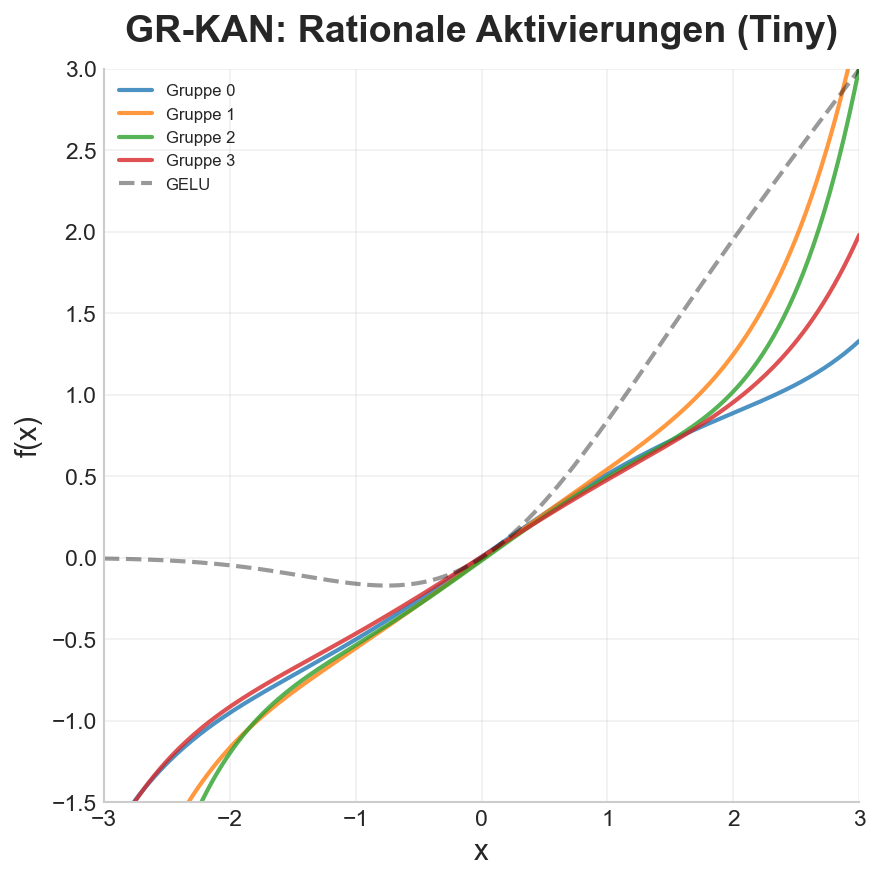

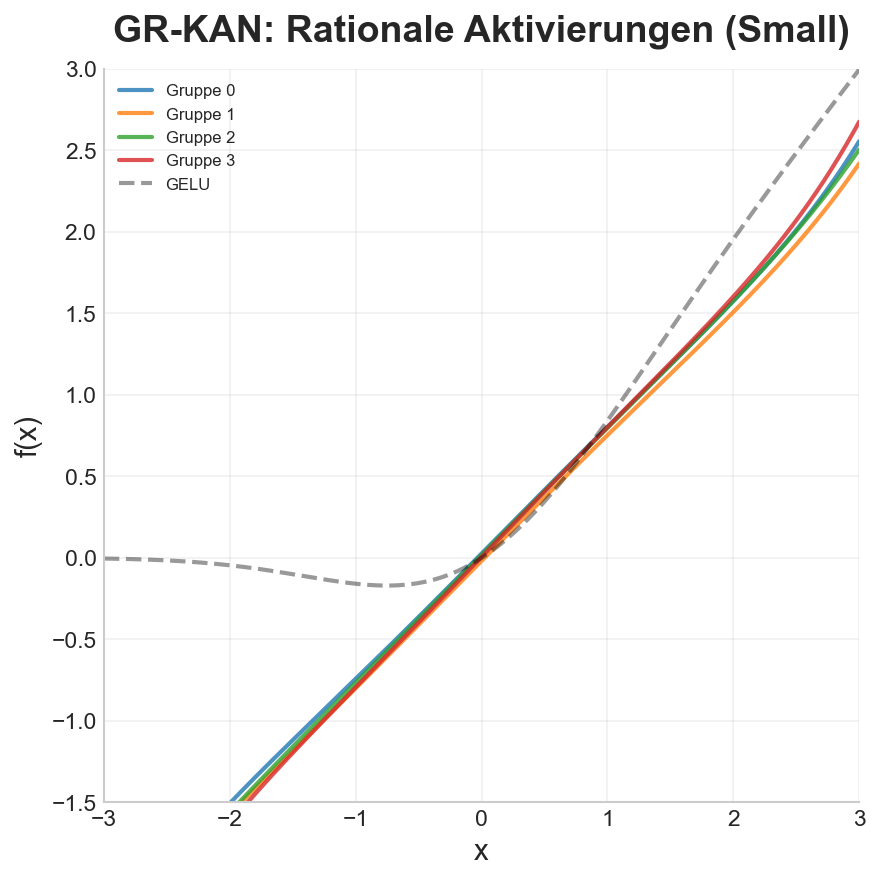

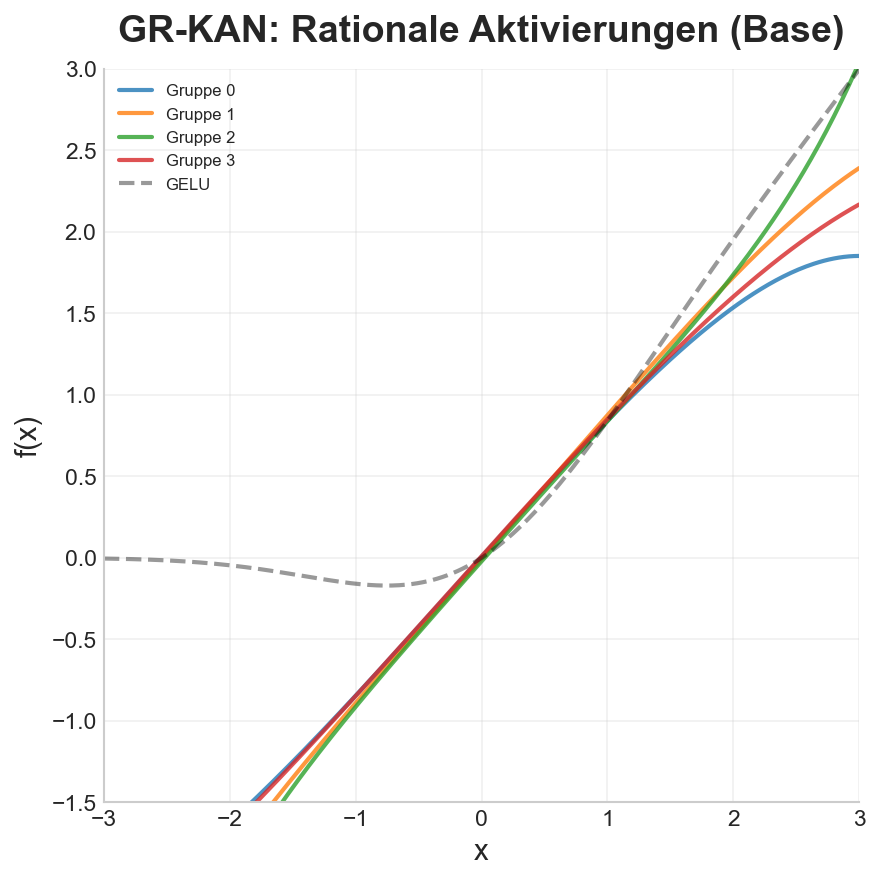

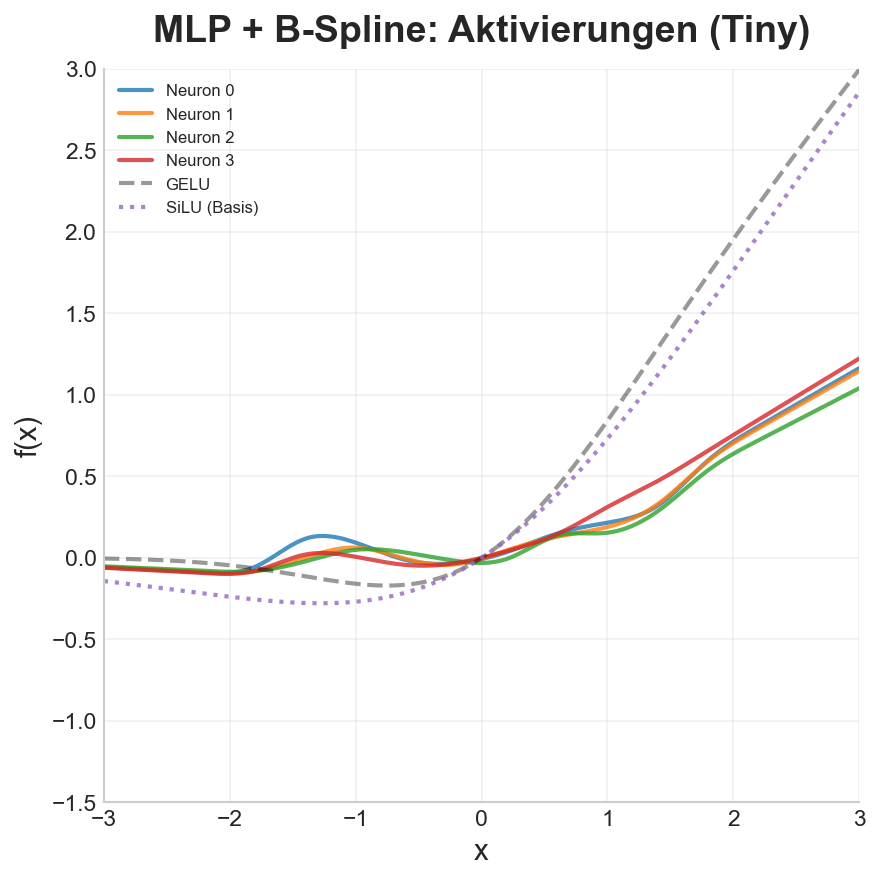

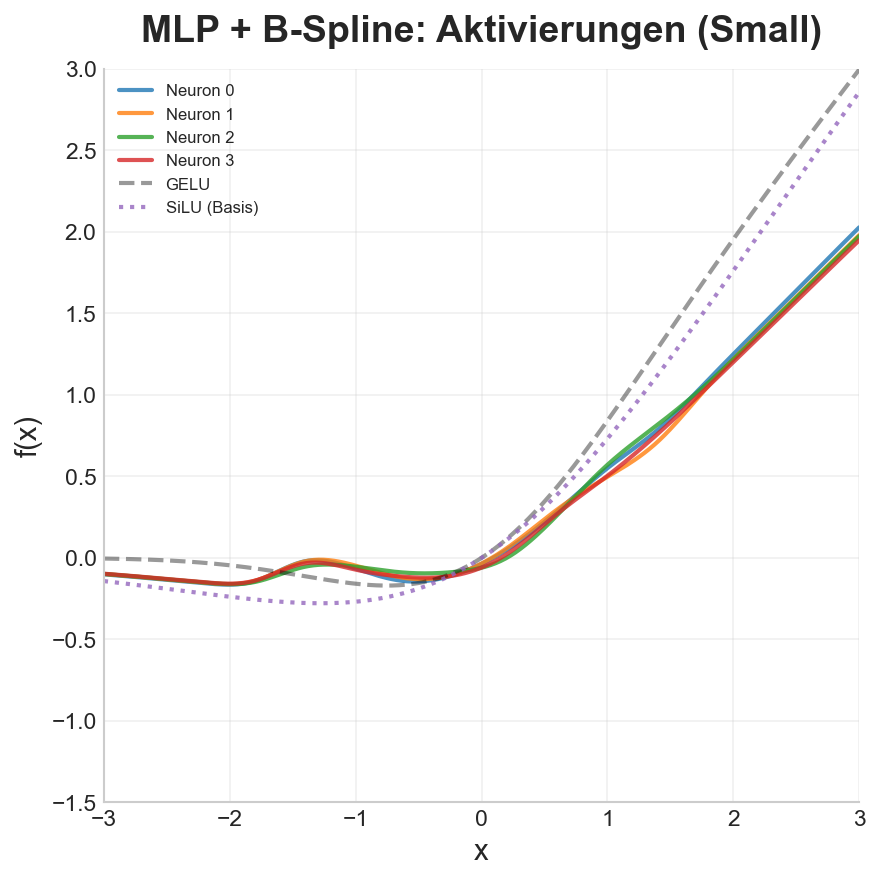

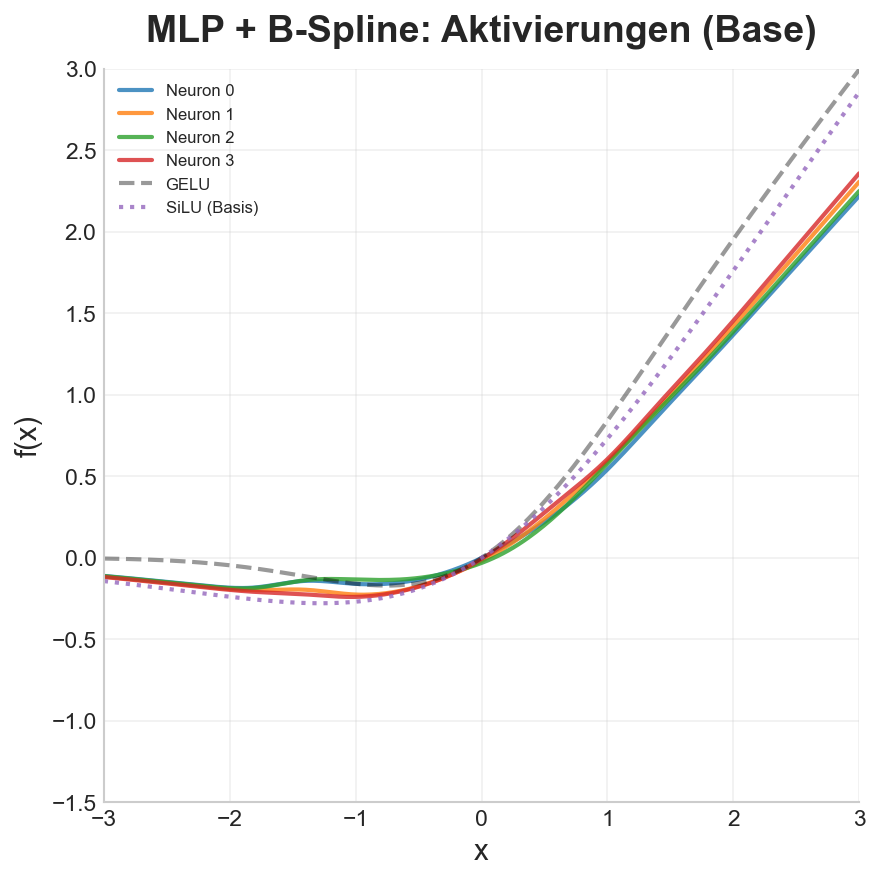

In [3]:
def plot_learned_grkan(models, size='tiny', seed=42):
    fig, axes = plt.subplots(1, 1, figsize=(6, 6))

    x = torch.linspace(-3, 3, 300)
    gelu_ref = F.gelu(x).numpy()

    # GR-KAN
    ax = axes
    model = models[size]['kan_grkan'][seed]
    model.eval()
    rational_act = model.layers[0].ffn.activations[0]
    dim = rational_act.dim
    n_groups = rational_act.n_groups
    group_size = dim // n_groups

    for g in range(4):
        x_input = torch.zeros(len(x), dim)
        x_input[:, g * group_size] = x
        with torch.no_grad():
            y = rational_act(x_input)[:, g * group_size].numpy()
        ax.plot(x.numpy(), y, linewidth=2, alpha=0.8, label=f'Gruppe {g}')

    ax.plot(x.numpy(), gelu_ref, 'k--', alpha=0.4, linewidth=2, label='GELU')
    ax.set_title(f'GR-KAN: Rationale Aktivierungen ({size.capitalize()})', y=1.02, fontweight='bold', fontsize=18)
    ax.set_xlim(-3, 3)
    ax.set_ylim(-1.5, 3)
    ax.legend(fontsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('x')
    ax.set_ylabel('f(x)')

    plt.tight_layout()
    plt.savefig(f'results/interpretability_activations_grkan_{size}.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_learned_bspline(models, size='tiny', seed=42):
    fig, axes = plt.subplots(1, 1, figsize=(6, 6))

    x = torch.linspace(-3, 3, 300)
    gelu_ref = F.gelu(x).numpy()
    silu_ref = F.silu(x).numpy()

    # MLP + B-Spline
    ax = axes
    model = models[size]['mlp_bspline'][seed]
    model.eval()
    bspline_act = model.layers[0].ffn.net[1]
    n_features = bspline_act.n_features if hasattr(bspline_act, 'n_features') else 768

    for i in range(4):
        x_input = torch.zeros(len(x), n_features)
        x_input[:, i] = x
        with torch.no_grad():
            y = bspline_act(x_input)[:, i].numpy()
        ax.plot(x.numpy(), y, linewidth=2, alpha=0.8, label=f'Neuron {i}')

    ax.plot(x.numpy(), gelu_ref, 'k--', alpha=0.4, linewidth=2, label='GELU')
    ax.plot(x.numpy(), silu_ref, ':', alpha=0.8, linewidth=2, label='SiLU (Basis)')
    ax.set_title(f'MLP + B-Spline: Aktivierungen ({size.capitalize()})', y=1.02, fontweight='bold', fontsize=18)
    ax.set_xlim(-3, 3)
    ax.set_ylim(-1.5, 3)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('x')
    ax.set_ylabel('f(x)')

    plt.tight_layout()
    plt.savefig(f'results/interpretability_activations_mlp_bspline_{size}.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_learned_grkan(models, 'tiny')
plot_learned_grkan(models, 'small')
plot_learned_grkan(models, 'base')
plot_learned_bspline(models, 'tiny')
plot_learned_bspline(models, 'small')
plot_learned_bspline(models, 'base')

In [14]:
# Raw data
df_raw.to_csv('results/interpretability_raw.csv', index=False)

# Agg data
df_agg.to_csv('results/interpretability_aggregated.csv', index=False)

In [ ]:
import os
import copy
from experiments.train import get_trainer
from experiments.prepare_datasets import get_dataloaders
from models.config import TRAINING_CONFIGS


def evaluate_soft_pruning(arch, model, size, seed, task="classification", threshold=0.01,
                          csv_file="results/pruning_results.csv"):
	device = get_device()

	# Load checkpoint
	ckpt_path = f"checkpoints/{task}_{arch}_{size}_s{seed}.pt"
	print(f"Loading checkpoint from {ckpt_path}...")

	try:
		state_dict = torch.load(ckpt_path, map_location=device, weights_only=True)
	except FileNotFoundError:
		print(f"ERROR: Checkpoint {ckpt_path} not found!")
		return None

	# _orig_mod prefix (torch.compile())
	new_state_dict = {}
	for k, v in state_dict.items():
		new_state_dict[k.replace("_orig_mod.", "")] = v

	# backup
	model.load_state_dict(new_state_dict)
	model.to(device)
	model.eval()
	original_state = copy.deepcopy(model.state_dict())

	# Pruning
	total_ffn_params = 0
	pruned_ffn_params = 0
	total_model_params = sum(p.numel() for p in model.parameters())

	with torch.no_grad():
		for name, module in model.named_modules():
			# KAN Layers
			if hasattr(module, 'spline_weight') and hasattr(module, 'spline_scaler'):
				w = module.spline_weight
				s = module.spline_scaler

				if module.enable_standalone_scale_spline:
					w_eff = w * s.unsqueeze(-1)
				else:
					w_eff = w * module.scale_spline

				mask_spline = w_eff.abs() > threshold

				n_spline = w.numel()
				n_pruned_spline = (1 - mask_spline.float()).sum().item()
				module.spline_weight.data *= mask_spline.float()

				n_base = 0
				n_pruned_base = 0
				if hasattr(module, 'base_weight'):
					n_base = module.base_weight.numel()
					mask_base = module.base_weight.abs() > threshold
					n_pruned_base = (1 - mask_base.float()).sum().item()
					module.base_weight.data *= mask_base.float()

				total_ffn_params += (n_spline + n_base)
				pruned_ffn_params += (n_pruned_spline + n_pruned_base)

			# MLP BSpline
			elif 'BSplineActivation' in str(type(module)):
				w = module.spline_weight
				s = module.spline_scale.unsqueeze(-1)
				w_eff = w * s
				mask = w_eff.abs() > threshold
				n_p = w.numel()
				n_pruned = (1 - mask.float()).sum().item()
				module.spline_weight.data *= mask.float()

				total_ffn_params += n_p
				pruned_ffn_params += n_pruned

			# Standard Linear Layers
			elif isinstance(module, torch.nn.Linear) and 'ffn' in name:
				w = module.weight
				mask = w.abs() > threshold
				n_p = w.numel()
				n_pruned = (1 - mask.float()).sum().item()
				# Hard Pruning
				module.weight.mul_(mask.float())
				total_ffn_params += n_p
				pruned_ffn_params += n_pruned

	sparsity_ffn = pruned_ffn_params / total_ffn_params if total_ffn_params > 0 else 0
	sparsity_global = pruned_ffn_params / total_model_params
	remaining_model_total = total_model_params - pruned_ffn_params
	compression_rate = total_model_params / remaining_model_total if remaining_model_total > 0 else 0

	print(f"FFN Sparsity: {sparsity_ffn:.2%}")
	print(f"Global Sparsity: {sparsity_global:.2%}")

	# Eval
	print("Evaluating pruned model...")
	# Dataloader
	seq_len = 512 if task == "classification" else 256
	train_loader, val_loader, test_loader, vocab_size, task_info = get_dataloaders(
		task=task, batch_size=TRAINING_CONFIGS[task]["batch_size"], seq_len=seq_len, is_ddp=False
	)

	trainer = get_trainer(
		task, model, train_loader, val_loader, 3e-4, device, TRAINING_CONFIGS[task]
	)

	metrics = trainer.evaluate(test_loader)
	test_loss, test_acc, test_f1, test_ppl = None, None, None, None

	if len(metrics) == 3:  # Classification: Loss, Acc, F1
		test_loss, test_acc, test_f1 = metrics
		metric_primary = test_acc
		metric_name = "Accuracy"
	elif len(metrics) == 2:  # Language Modelling: Loss, PPL
		test_loss, test_ppl = metrics
		metric_primary = test_ppl
		metric_name = "Perplexity"
	else:
		test_loss = metrics[0]
		metric_primary = test_loss
		metric_name = "Loss"

	print(f"Test {metric_name}: {metric_primary:.4f}")

	# save to disk
	row_data = {
		'task': task,
		'arch': arch,
		'size': size,
		'seed': seed,
		'threshold': threshold,
		'sparsity_ffn': sparsity_ffn,
		'sparsity_global': sparsity_global,
		'params_original': total_model_params,
		'params_effective': remaining_model_total,
		'compression_rate': compression_rate,
		'test_loss': test_loss,
		'test_acc': test_acc,
		'test_f1': test_f1,
		'test_ppl': test_ppl
	}

	# DataFrame
	df = pd.DataFrame([row_data])
	file_exists = os.path.isfile(csv_file)

	# Append
	df.to_csv(csv_file, mode='a', header=not file_exists, index=True)
	print(f"Logged results to {csv_file}")

	# Restore old state
	model.load_state_dict(original_state)

	return row_data


for size in ["base"]:
	for arch in ["mlp_bspline"]:
		for seed in models[size][arch]:
			print(evaluate_soft_pruning(arch, models[size][arch][seed], size, seed, "classification"))


Loading checkpoint from checkpoints/language_modelling_mlp_bspline_base_s42.pt...
FFN Sparsity: 30.18%
Global Sparsity: 13.82%
Evaluating pruned model...
Train chunks: 105,062
Val chunks: 5,836
Test chunks: 5,836
